# Milestone 01
# Kent Go

Assume the 591 attributes represent different sensors readings across the manufacturing process. 

Using the SECOM dataset, create a new notebook, and perform each of the following tasks and answer the related questions:

1. Refine your data understanding and prepare a DFD of solving the manufacturing quality problem
1. Read and merge data
1. Clean and prepare data 
1. Visually explore data
1. Handle class imbalance problem
1. Apply feature selection techniques to reduce dimensionality of data
1. What are your initial findings? Describe them in a summary section

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV, Lasso
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.feature_selection import RFE
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from sklearn.metrics import mutual_info_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

%matplotlib inline

## 1. Data Flow Diagram

We will create a Data Flow Diagram to lay out the steps and the flow of information to solve the manufacturing quality problem. Please see DFD file attached.

## 2. Read & Merge Data

We will read two datasets (feature set and data & target set), assign column names and merge them.

In [2]:
#read & merge data

url1 = 'https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data'

url2 = 'https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data'


fnames = ['feature' + str(x) for x in range(1, 591)]
df1 = pd.read_csv(url1, sep=' ', header=None, names=fnames, na_values=np.NaN) 

df2 = pd.read_csv(url2, sep=' ', names=['result','date'], parse_dates=['date'], na_values=np.NaN)

df = pd.concat([df1, df2], axis=1)

print('Dataset shape:', df.shape, '\n')

df.head()

Dataset shape: (1567, 592) 



,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590,result,date
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1,2008-07-19 11:55:00
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1,2008-07-19 12:32:00
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1,2008-07-19 13:17:00
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1,2008-07-19 14:43:00
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1,2008-07-19 15:22:00


## 3. Clean & Prepare Data

In [3]:
#remove features that are missing more than 50% of their values

missing = pd.DataFrame(df.isnull().sum()/len(df) > 0.5).rename(columns={0: '50%+'})
df2 = df.loc[:, ~missing['50%+']]

#remove non-predictive date feature
df2 = df2.drop('date', axis=1)

print('Shape of Dataset after Removing Features with 50% missing values: ', df2.shape)

Shape of Dataset after Removing Features with 50% missing values:  (1567, 563)


We removed the date feature (non-predictive) and 28 other features that are missing more than 50% of the entries. Our cleaned dataset now has 562 features and 1 target.

In [4]:
#replace remaining missing values with the median value of the feature

df2.replace(np.NaN, df2[df2.columns].median(), inplace=True)

df2.head()

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature578,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590,result
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,14.9509,0.5005,0.0118,0.0035,2.3630,0.0205,0.0148,0.0046,71.9005,-1
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,10.9003,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,9.2721,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,8.5831,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,10.9698,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


We will scale the dataset to prevent features with high magnitudes to have more weight in the distance calculations than features with low magnitudes.

In [5]:
#standardize features

df_scaled = df2.copy(deep = True)

for col in df2.drop('result', axis=1).columns:
    df_scaled[col] = StandardScaler().fit_transform(df2[col].values.reshape(-1, 1))

df_scaled.head()

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature578,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590,result
0,0.224463,0.849523,-0.436430,0.035804,-0.050121,0.0,-0.564354,0.265894,0.509848,1.128455,...,-0.135520,0.118679,-0.204833,-0.093165,-0.197057,-0.077554,-0.190165,-0.238334,-0.295753,-1
1,1.107287,-0.383106,1.016977,0.155282,-0.059585,0.0,0.197639,0.321868,0.457021,0.022620,...,-0.460054,0.530183,0.406734,0.444748,0.385113,-0.960123,0.411970,0.250272,1.156846,-1
2,-1.114000,0.798901,-0.481447,0.688278,-0.047447,0.0,-0.906768,0.254699,-0.260885,0.327222,...,-0.590505,-1.262799,0.022320,0.014418,0.029888,2.991195,3.627143,3.321511,-0.178955,1
3,-0.350156,-0.199072,-0.051705,-1.104376,-0.050831,0.0,0.502662,-0.013974,0.343240,-0.765369,...,-0.645708,-0.322218,-0.292200,-0.362121,-0.283360,-0.101845,-0.178804,-0.308135,-0.275049,-1
4,0.242296,0.087328,1.117227,-0.156616,-0.047033,0.0,-0.115954,0.187531,0.545066,-0.149545,...,-0.454486,-5.906917,26.867221,27.071429,26.913337,-0.101845,-0.178804,-0.308135,-0.275049,-1


## 4. Exploratory Data Analysis (EDA)

Before performing any modeling, we will explore the data visually to understand the dataset better. We will plot the distribution of the target as well as the feature variables.

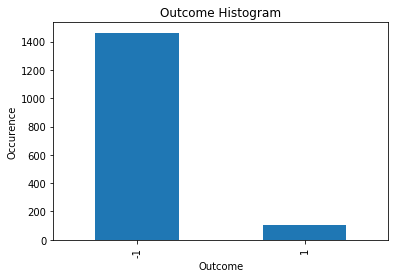

Outcomes: 
 -1    1463
 1     104
Name: result, dtype: int64


In [6]:
#plot histogram of the outcome

df_scaled['result'].value_counts().plot(kind='bar')
plt.title('Outcome Histogram')
plt.xlabel('Outcome')
plt.ylabel('Occurence')
plt.show()

print('Outcomes: \n', df_scaled['result'].value_counts())

/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


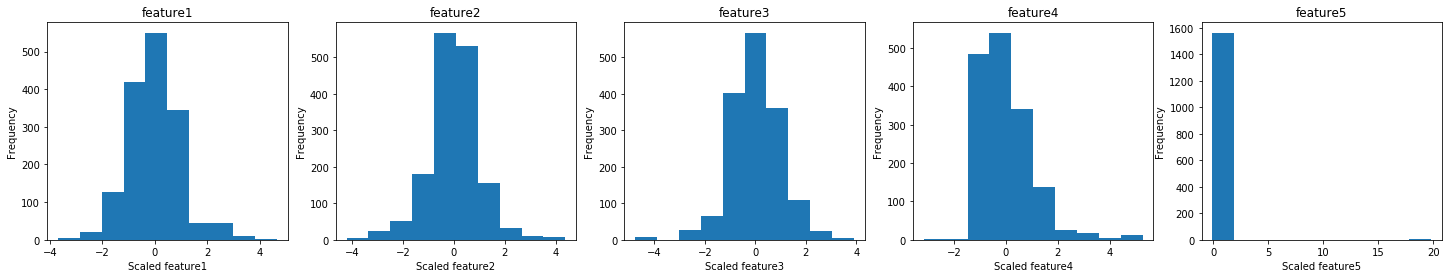

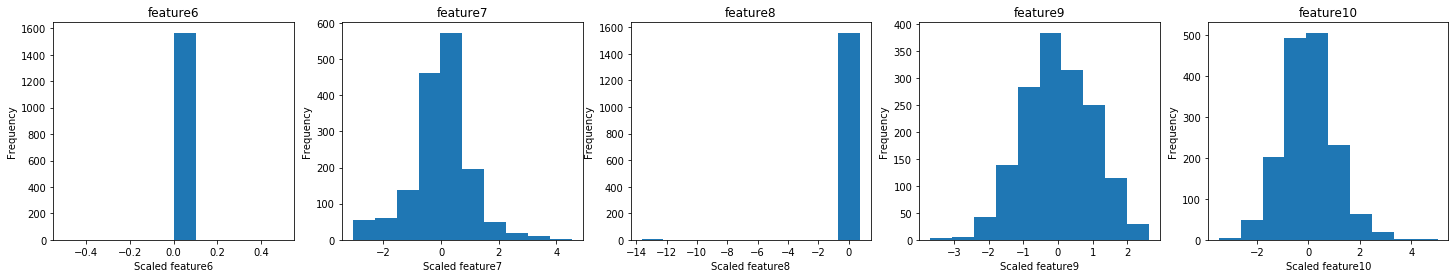

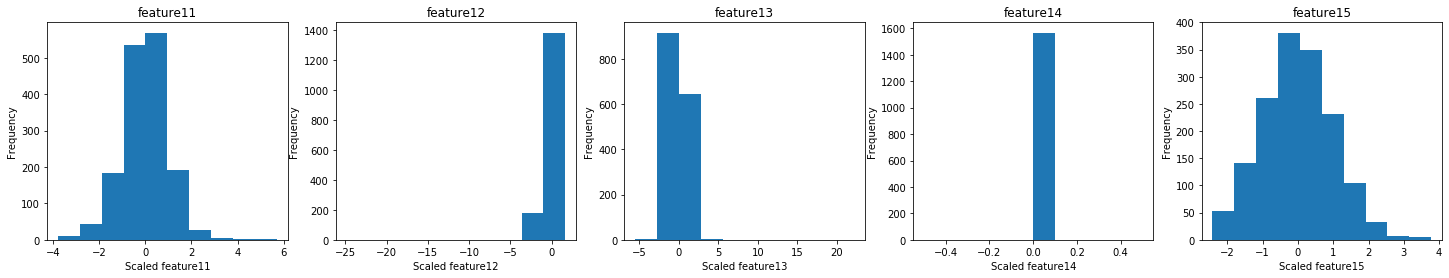

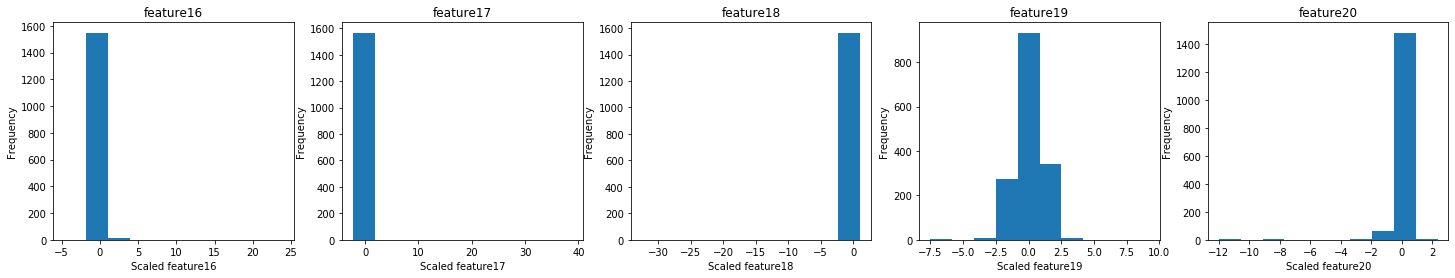

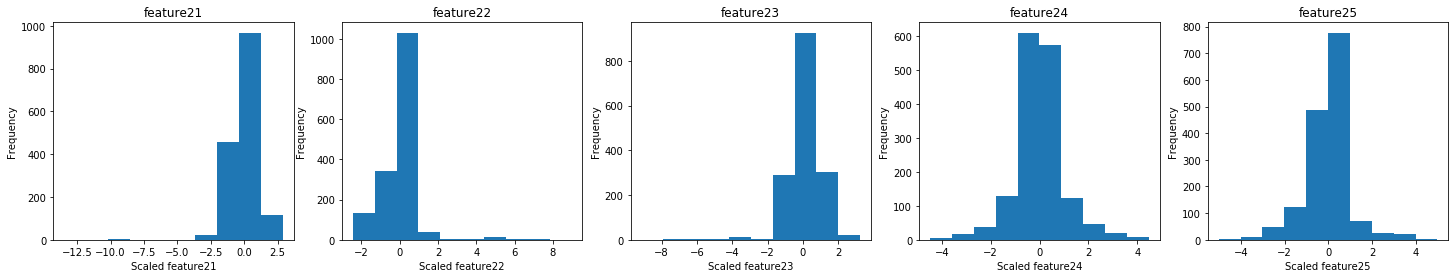

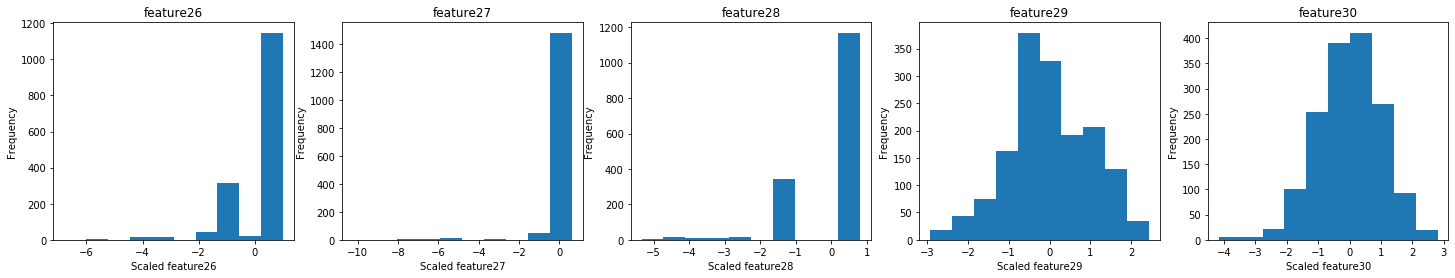

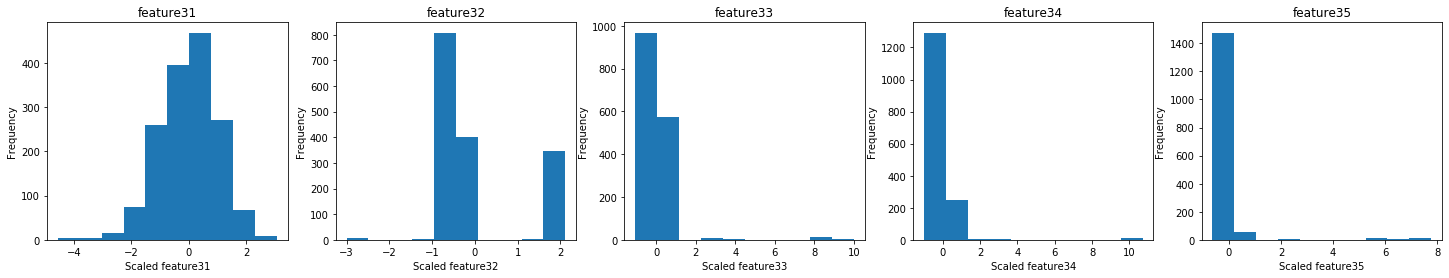

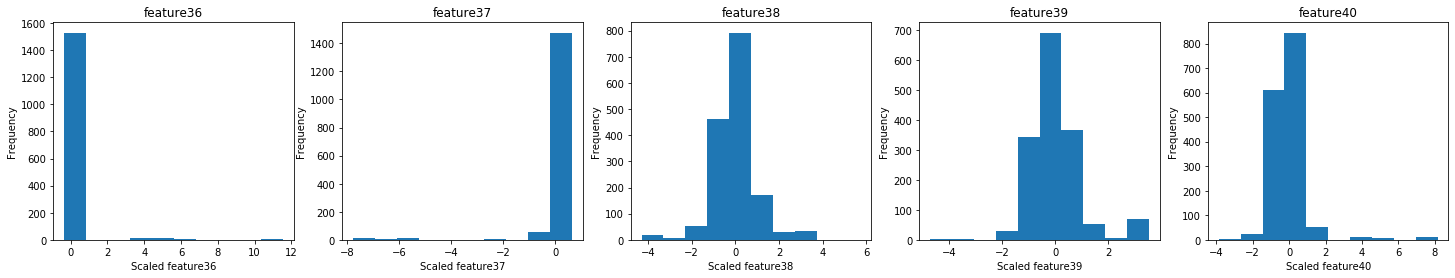

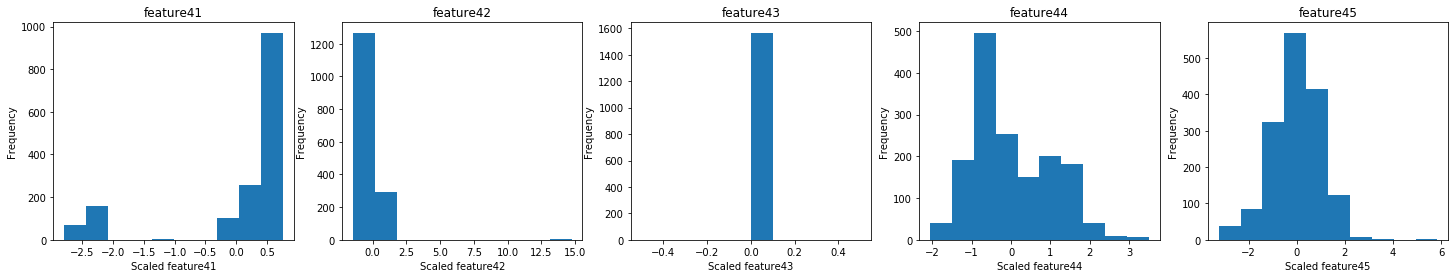

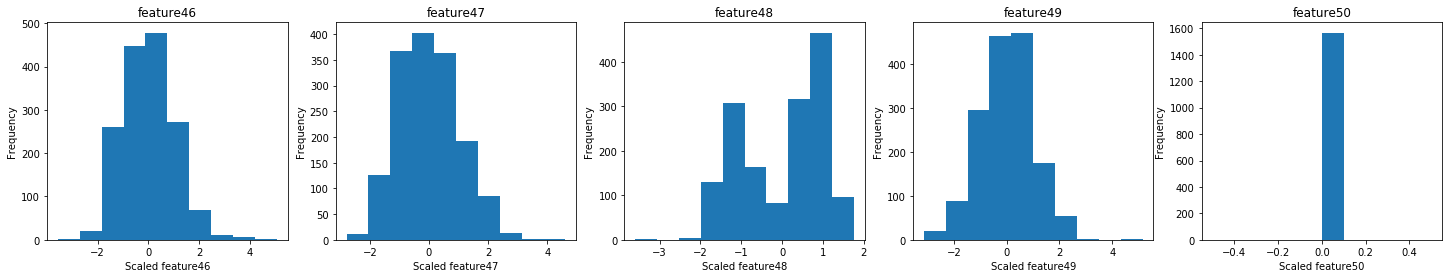

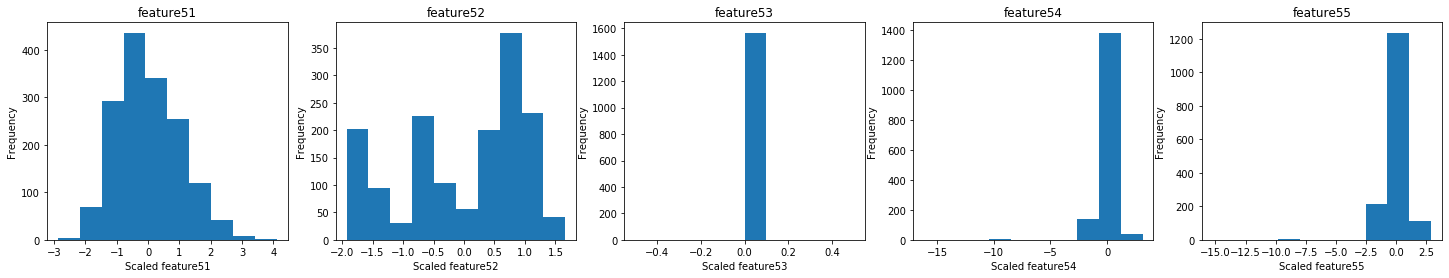

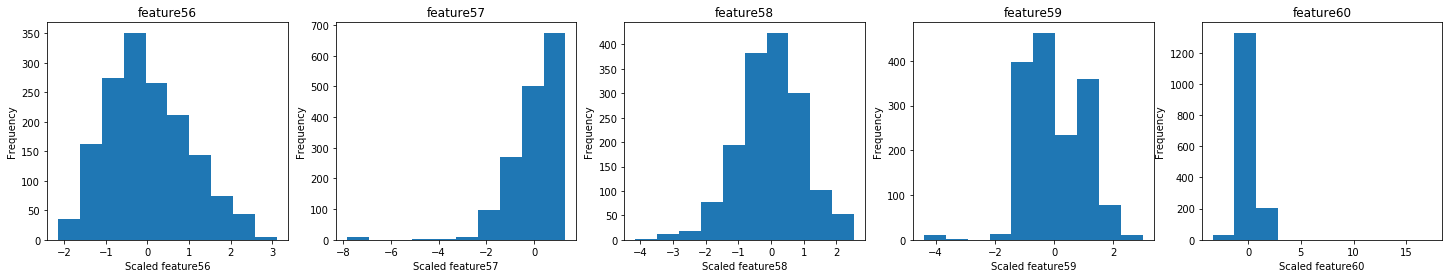

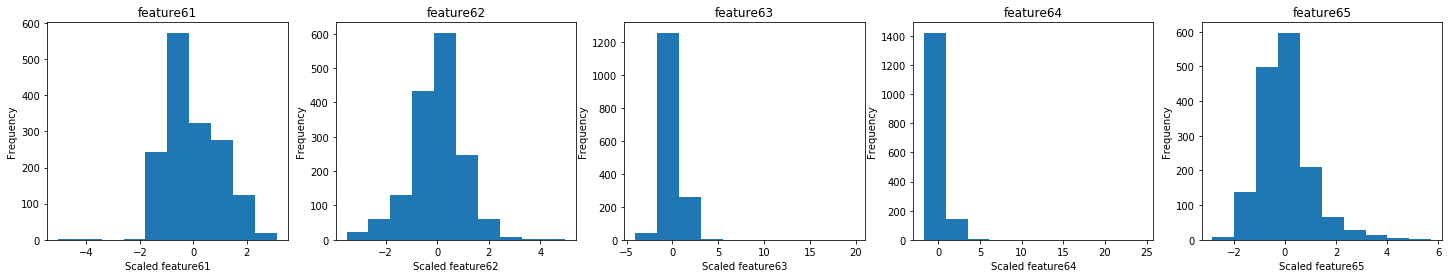

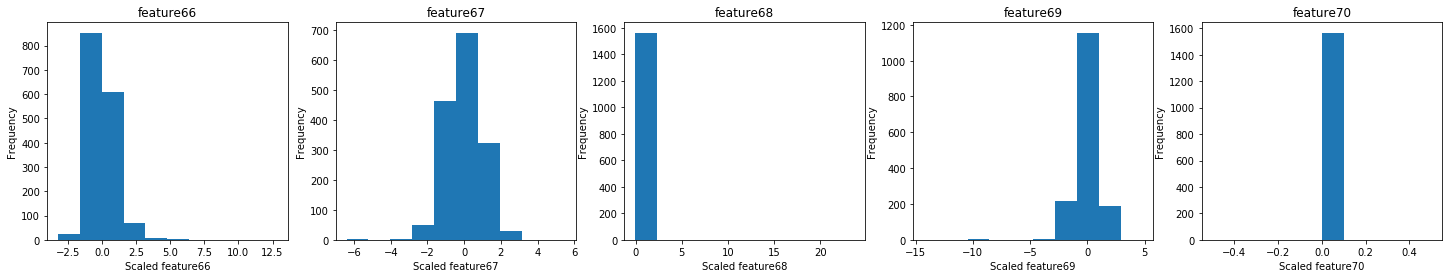

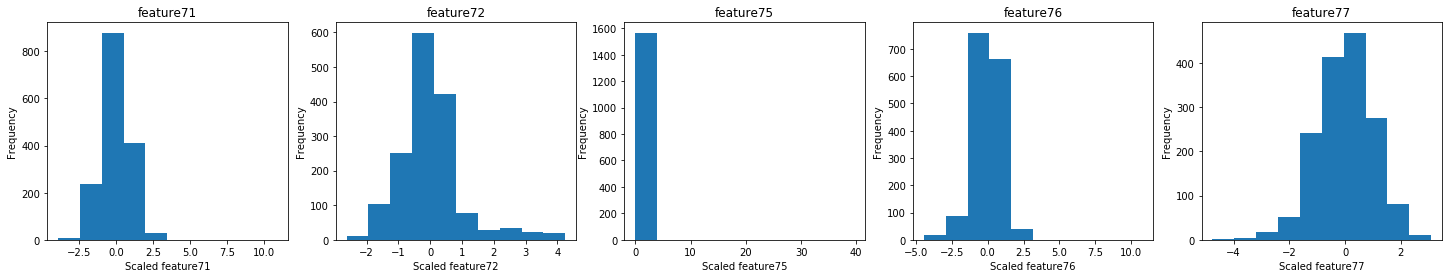

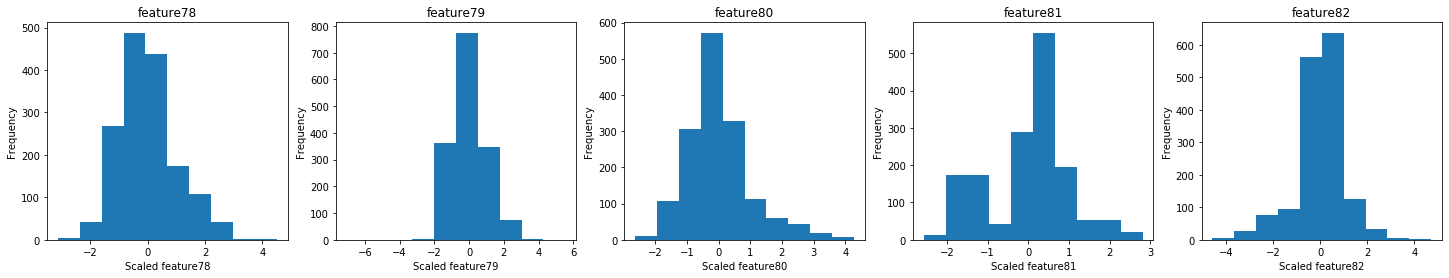

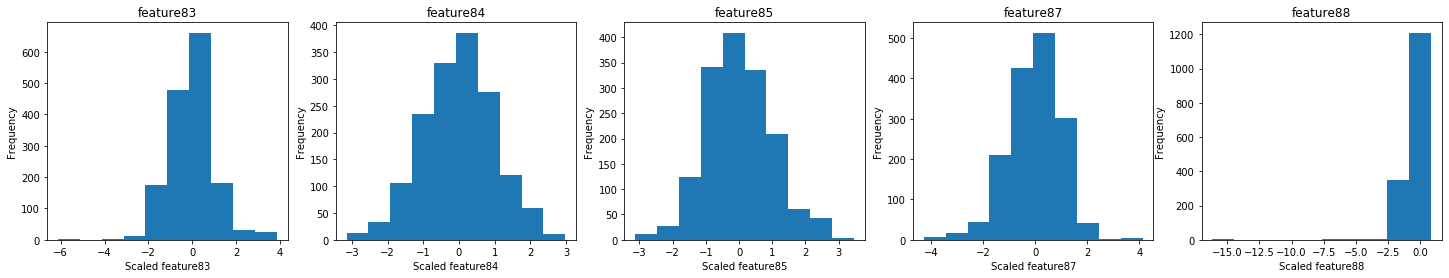

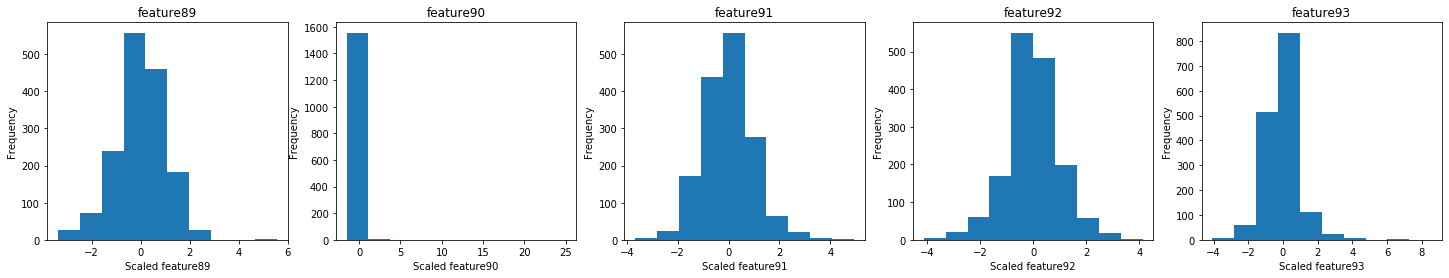

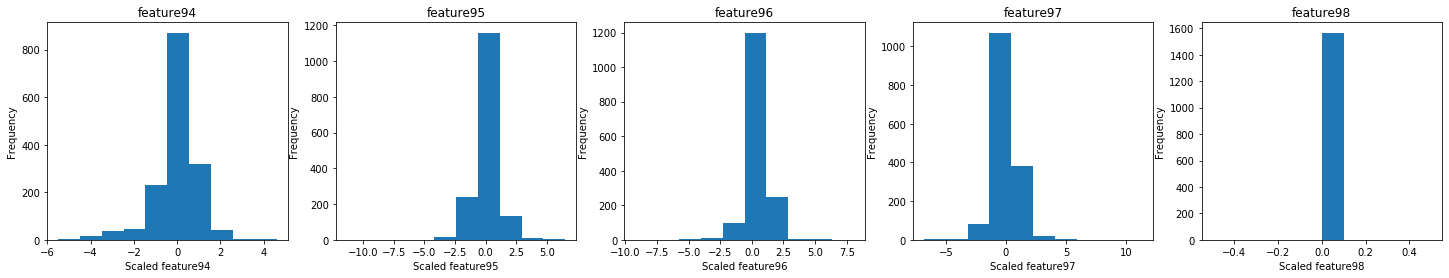

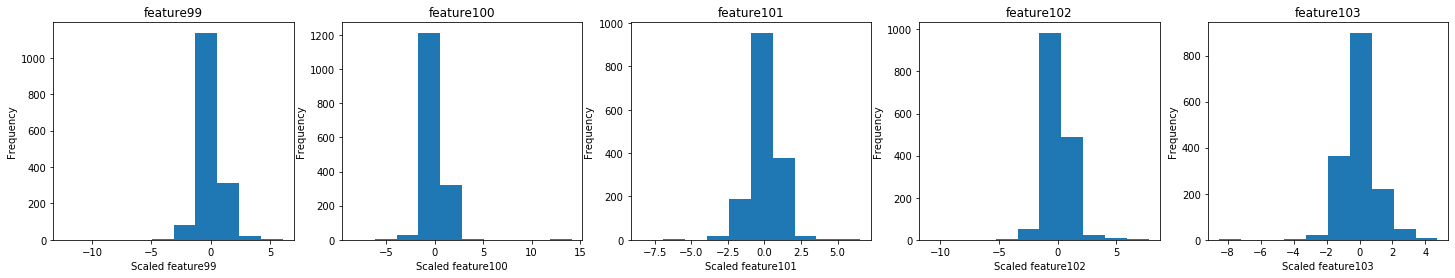

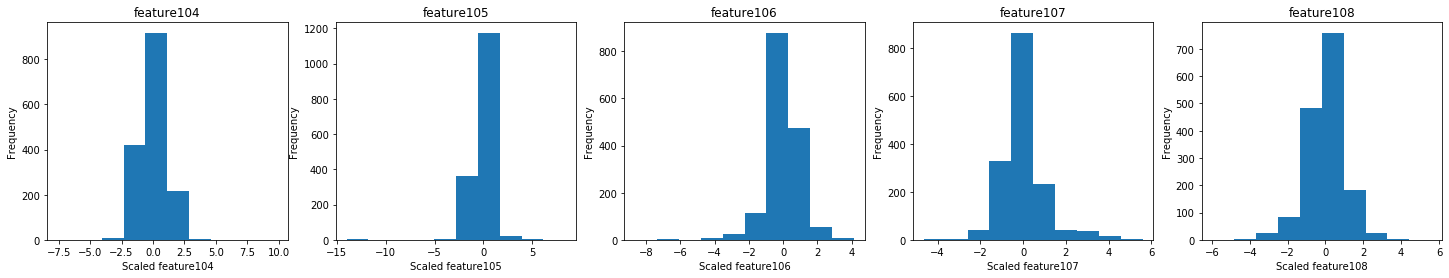

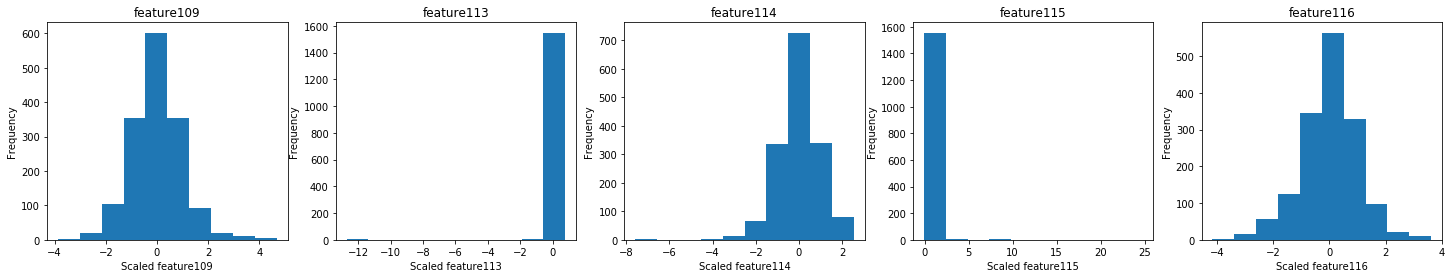

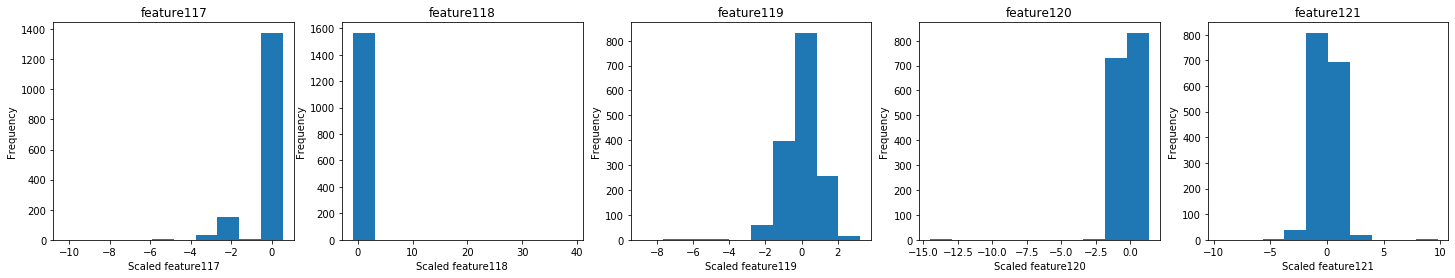

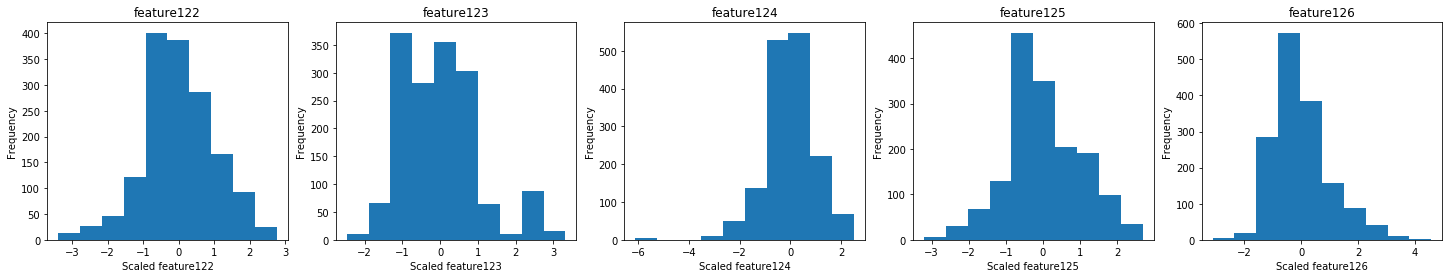

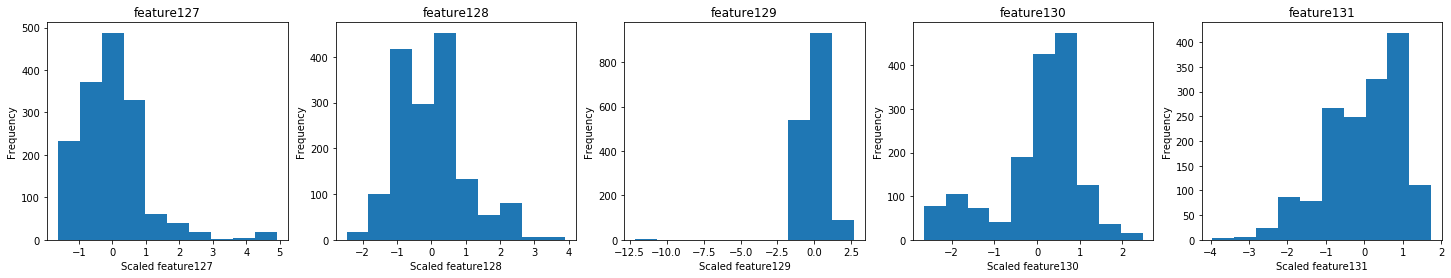

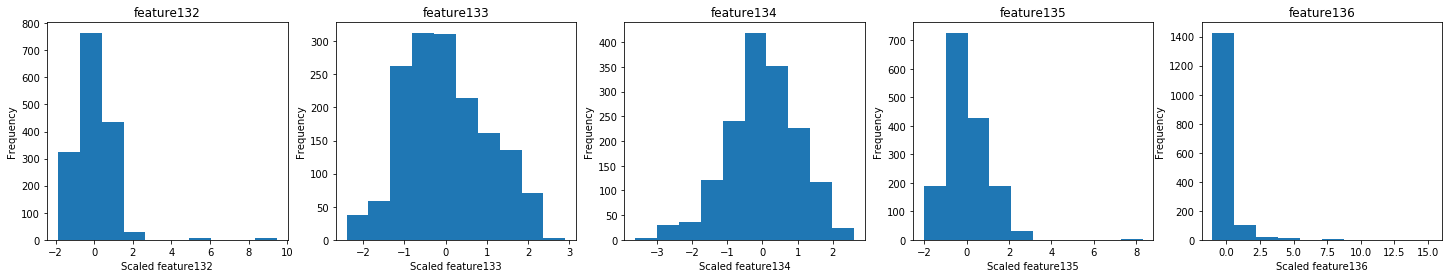

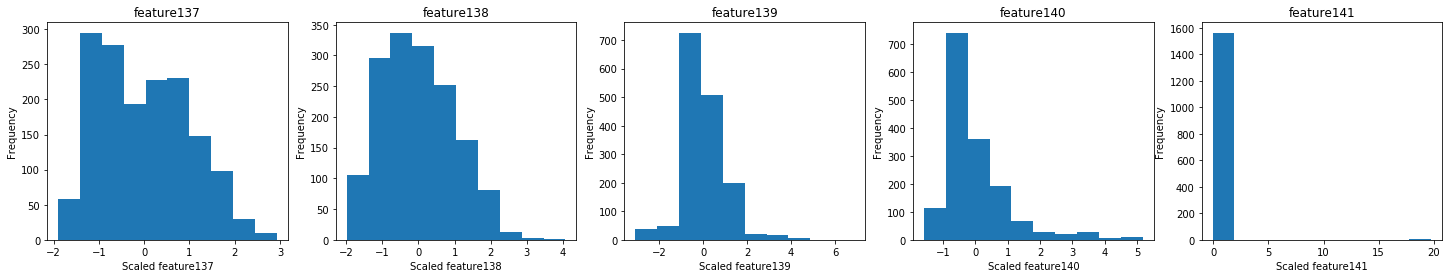

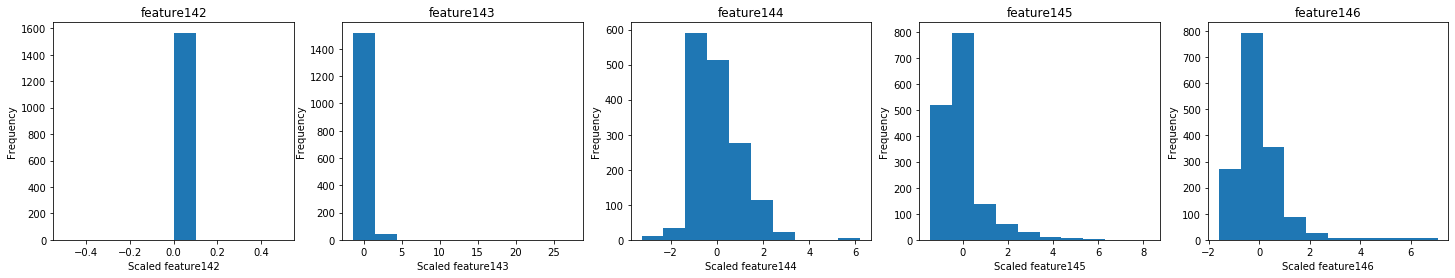

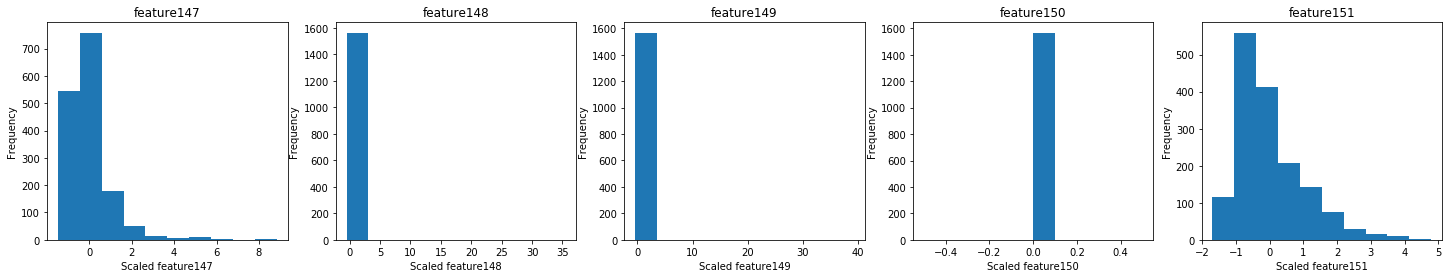

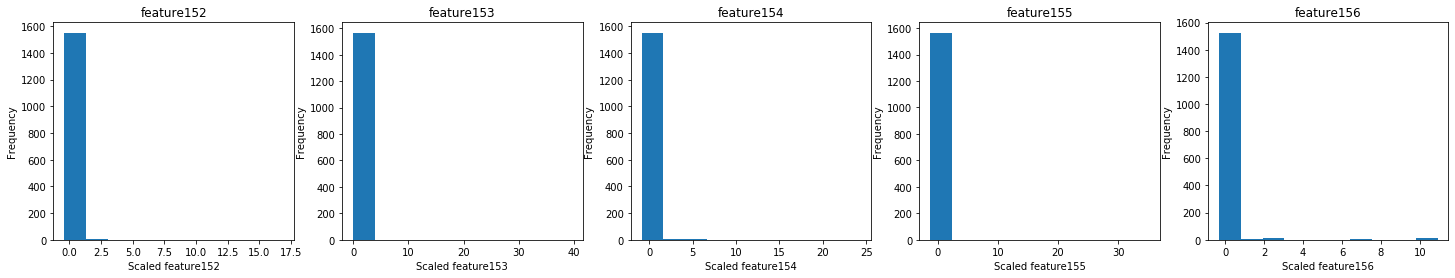

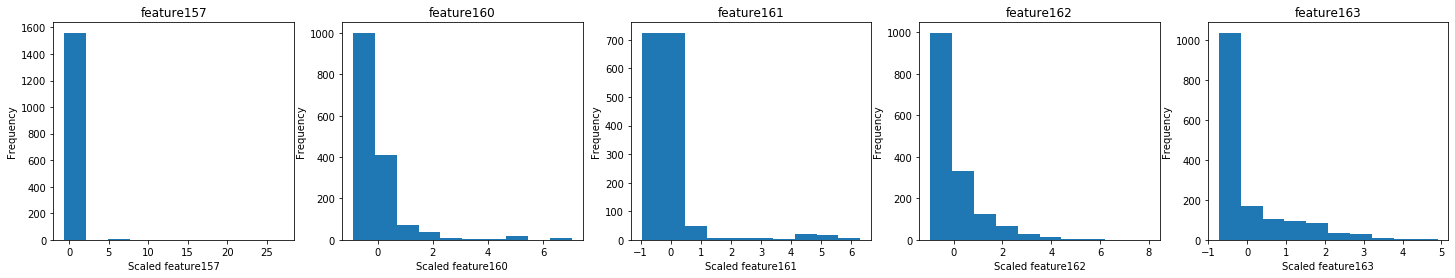

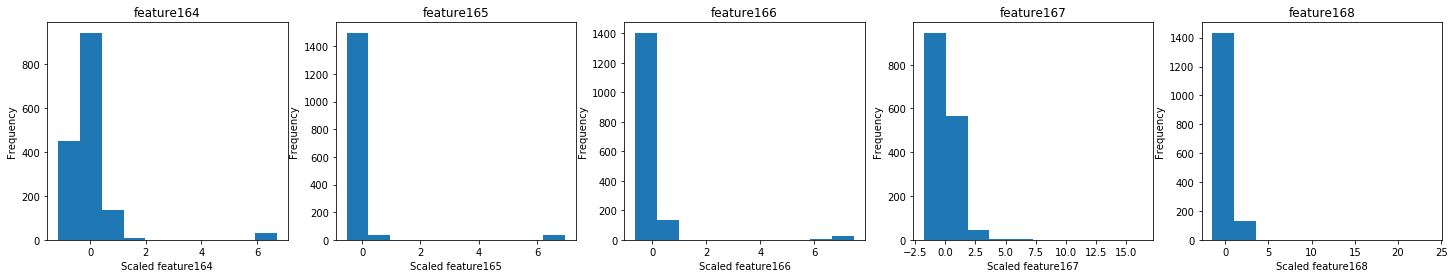

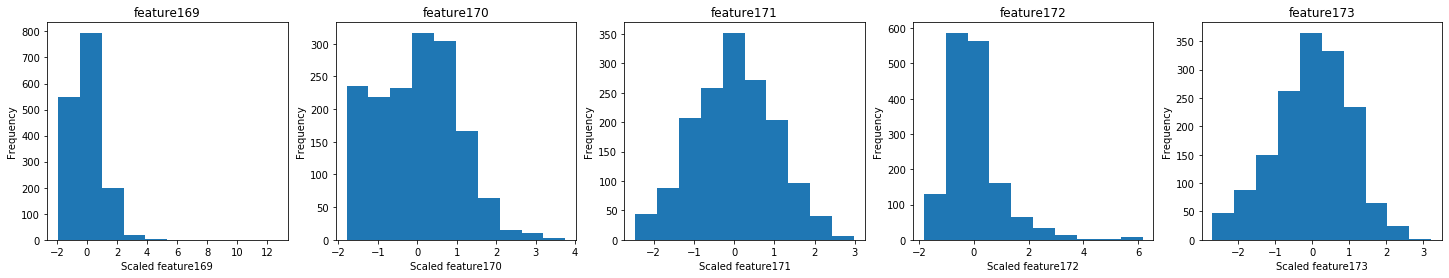

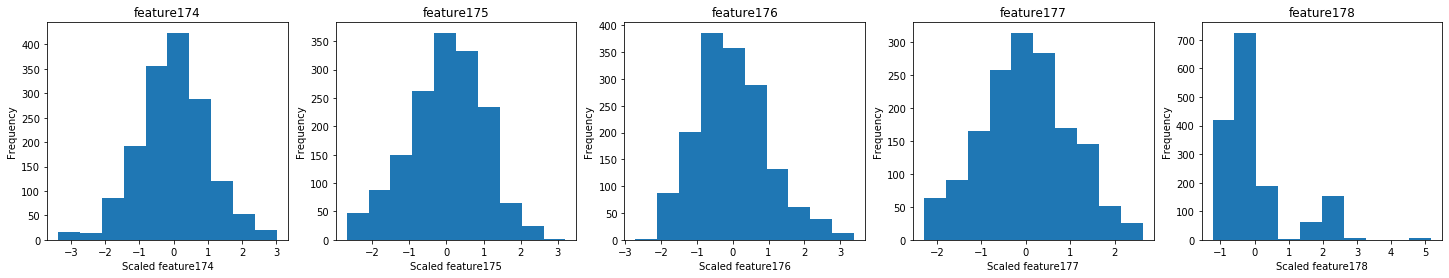

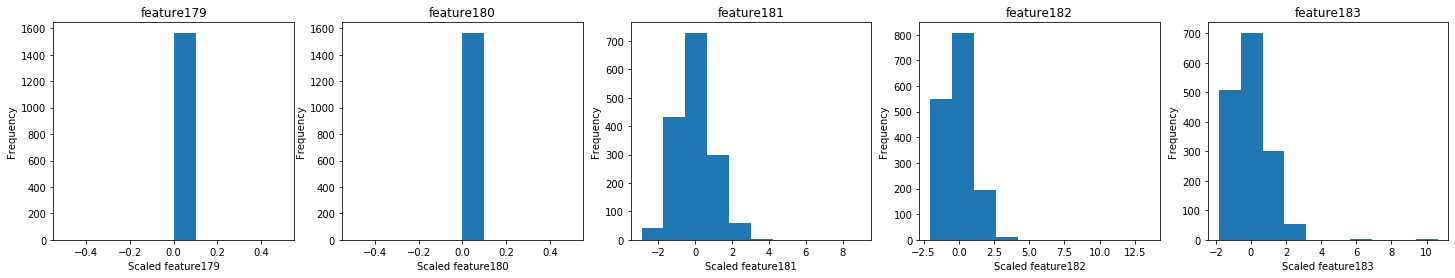

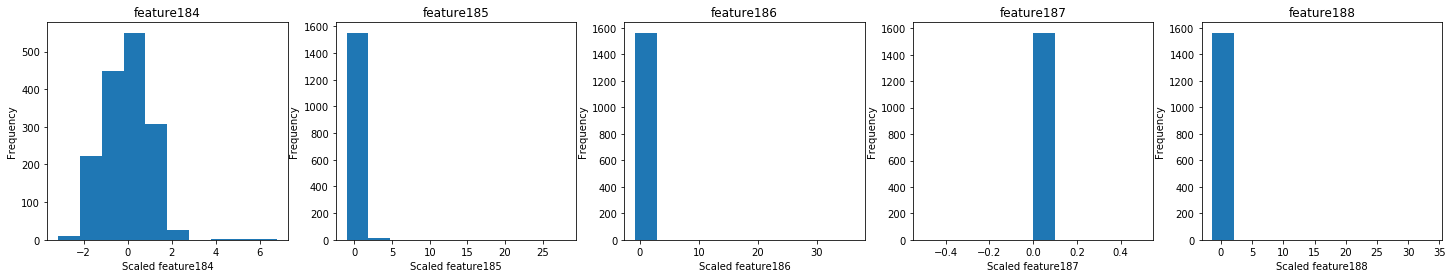

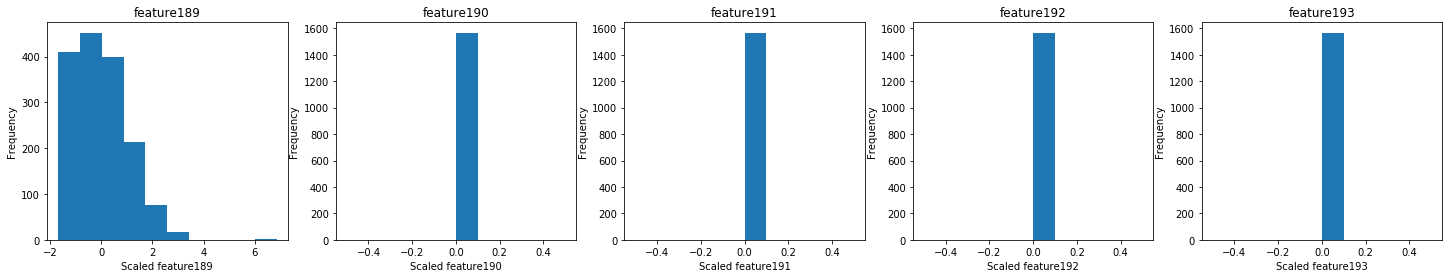

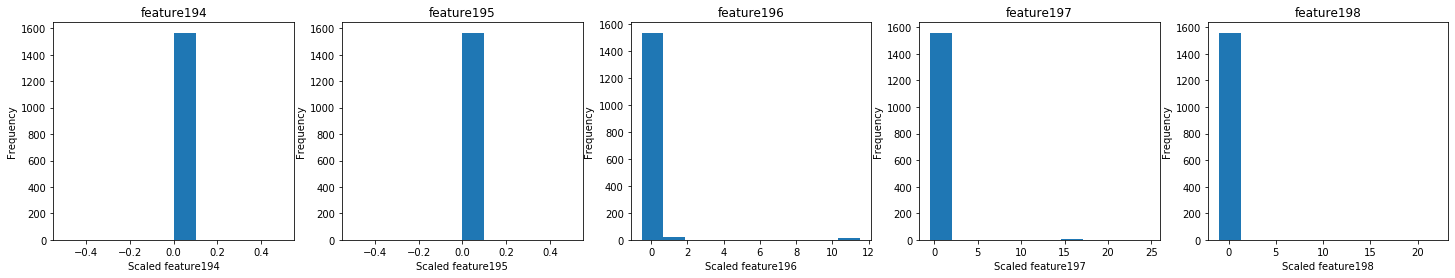

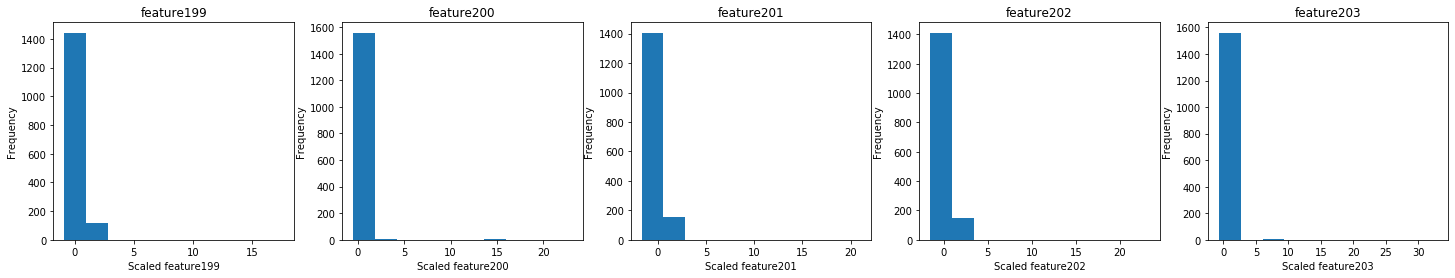

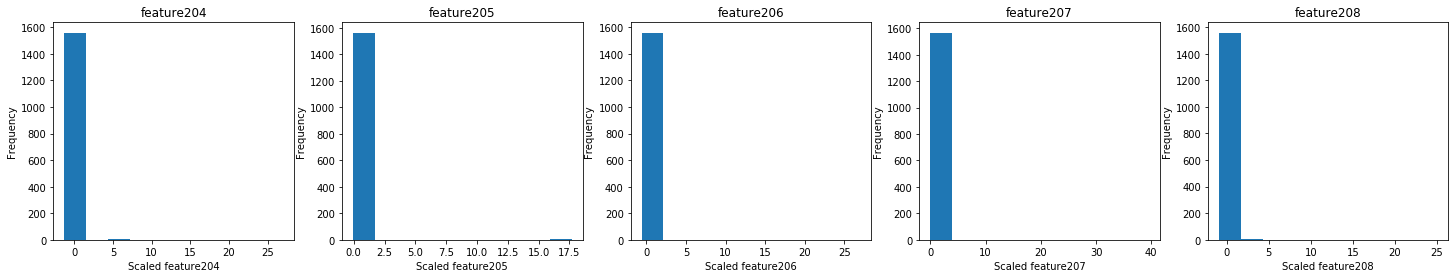

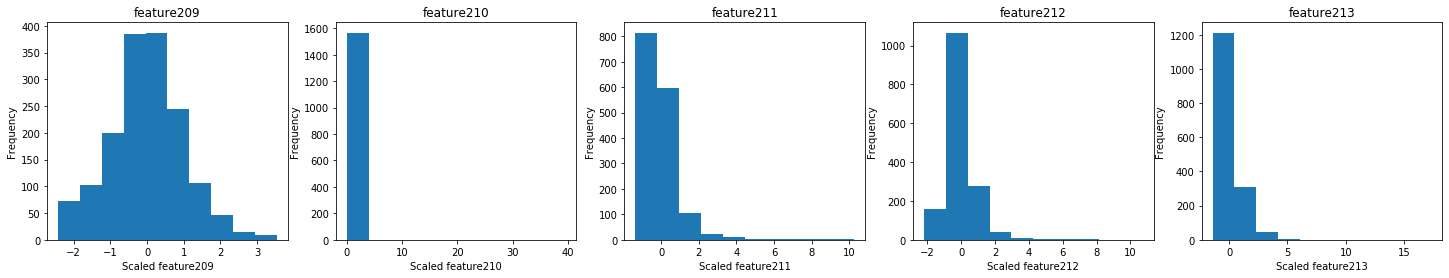

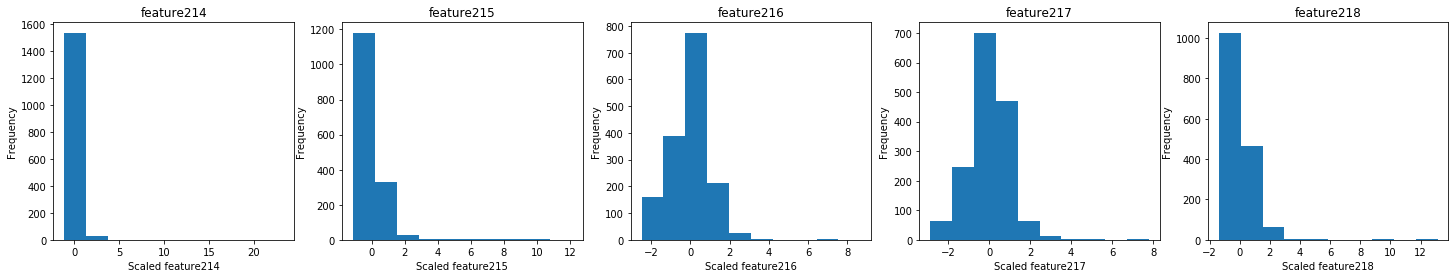

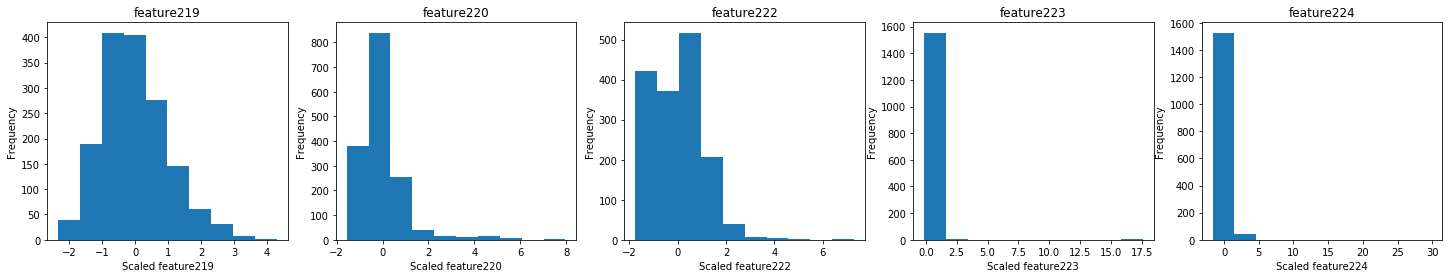

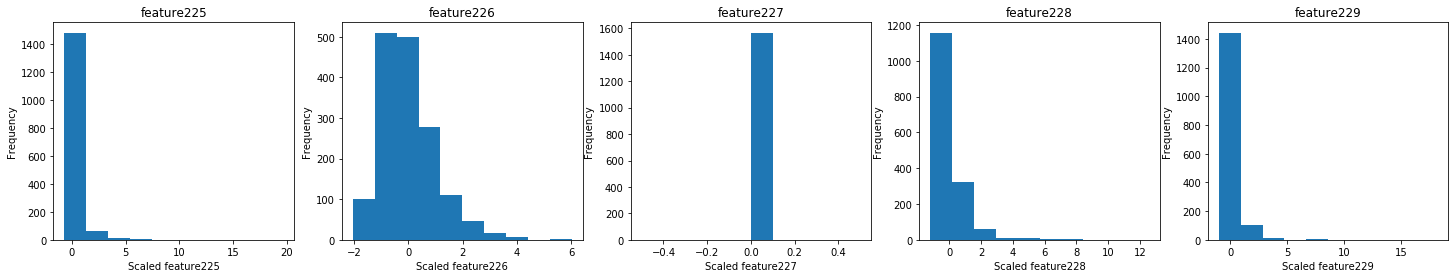

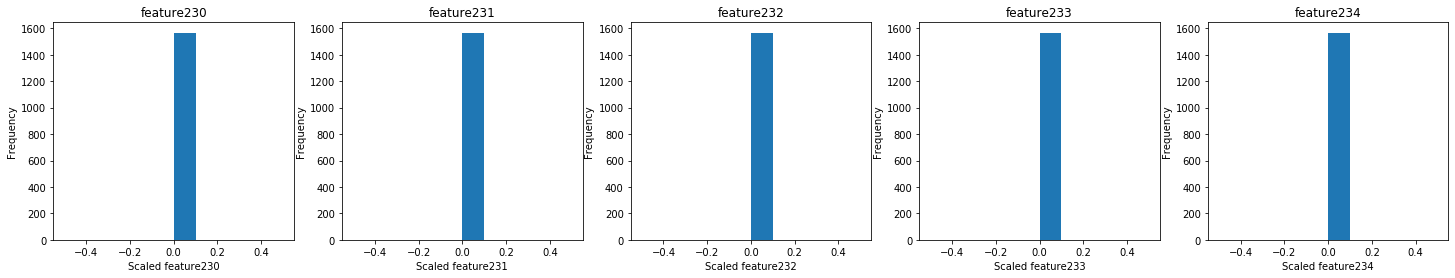

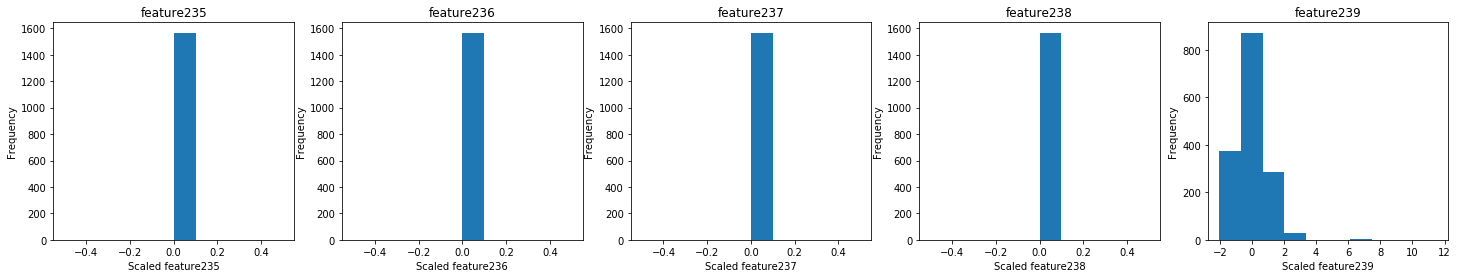

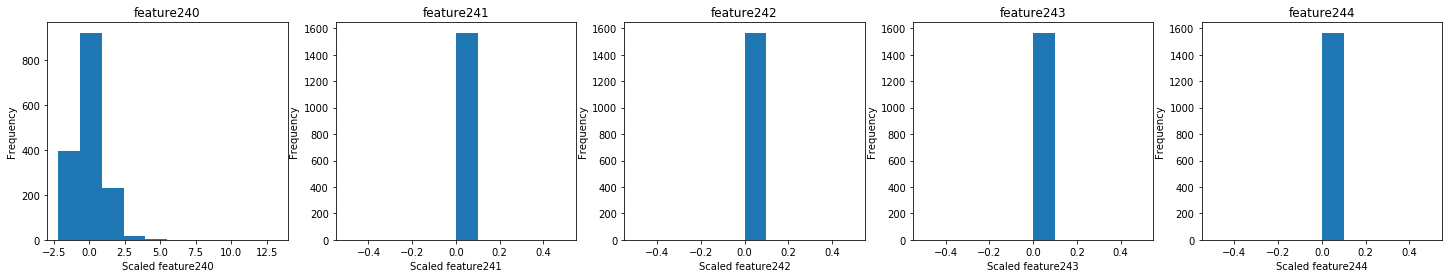

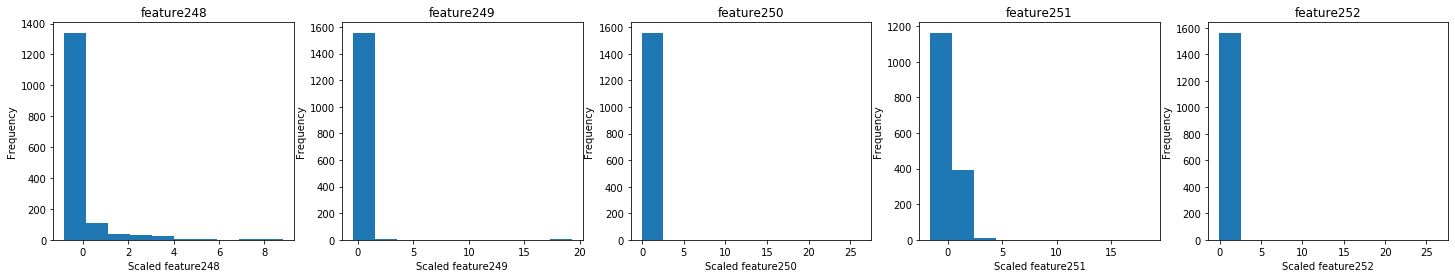

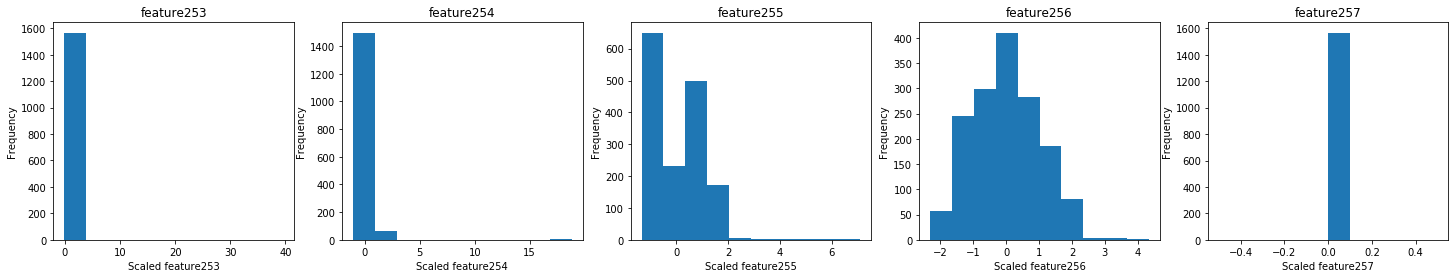

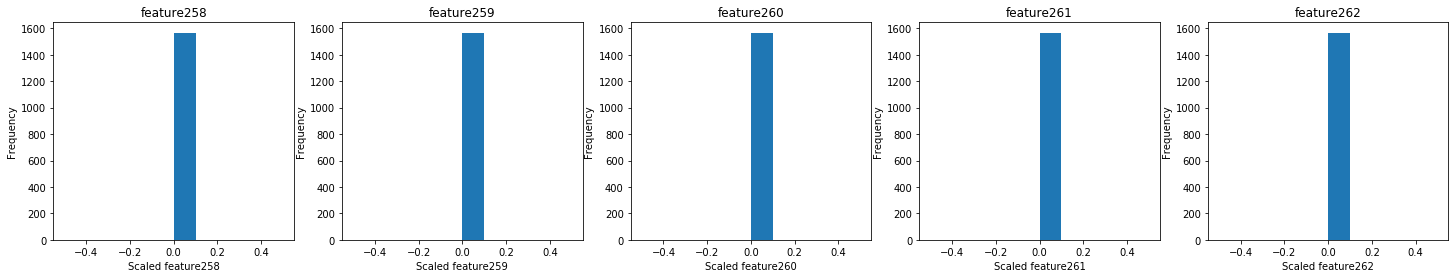

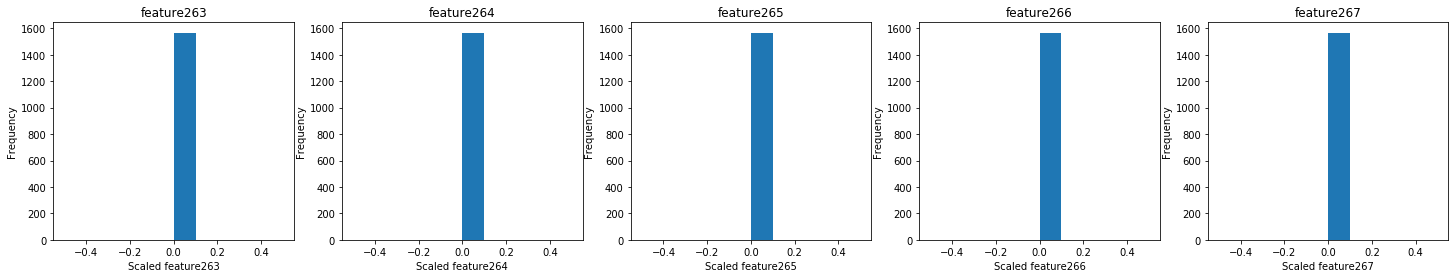

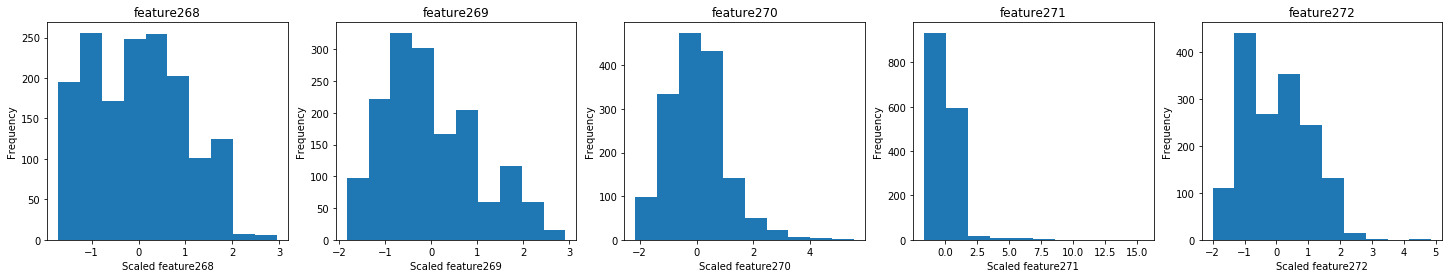

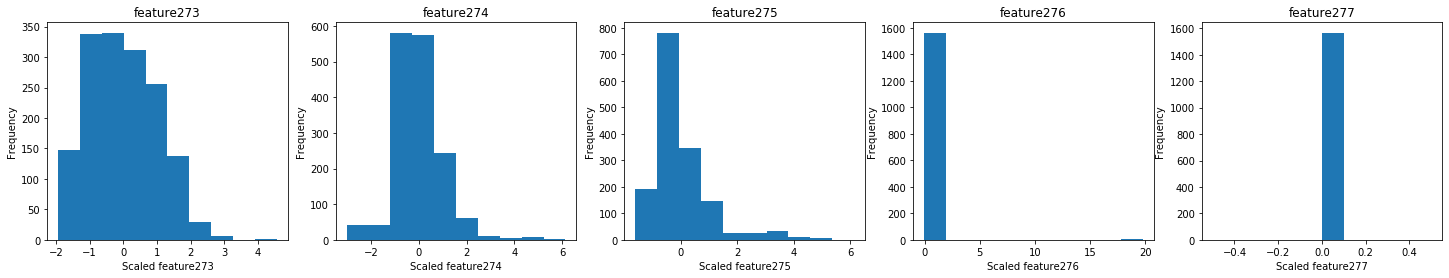

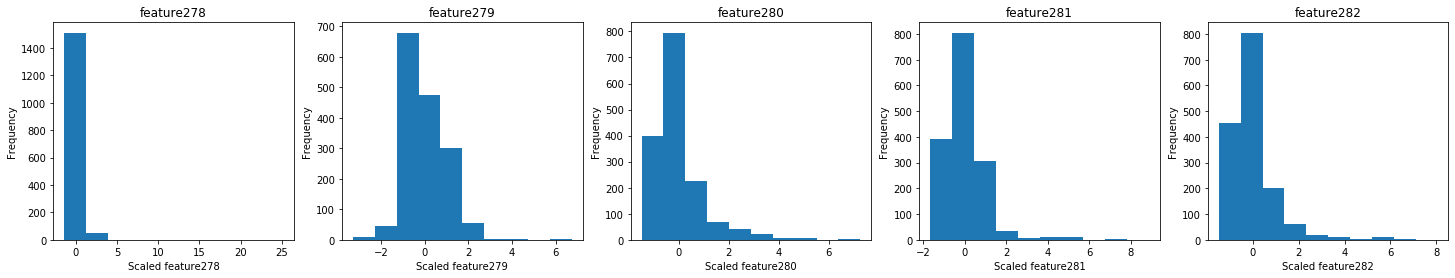

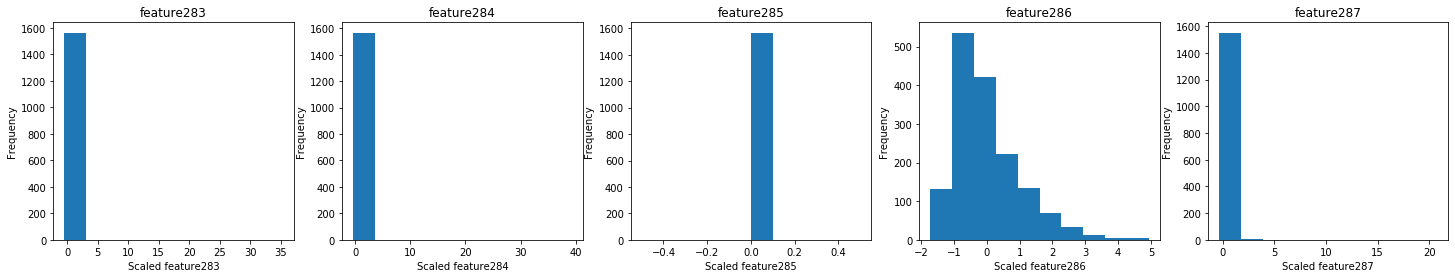

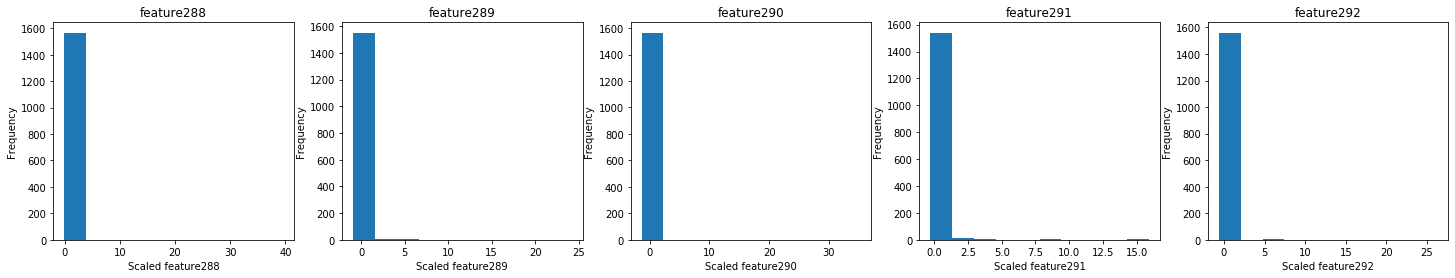

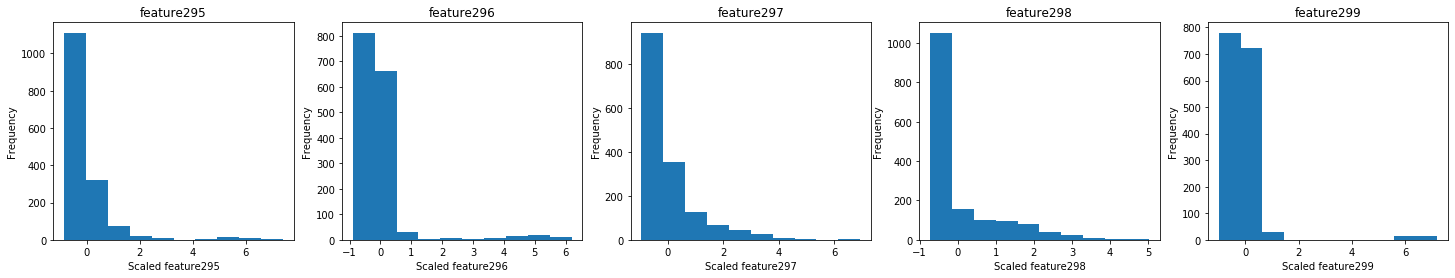

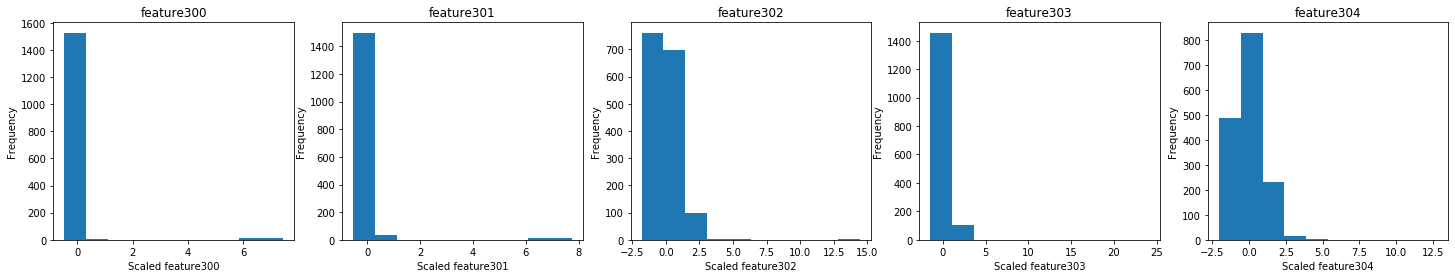

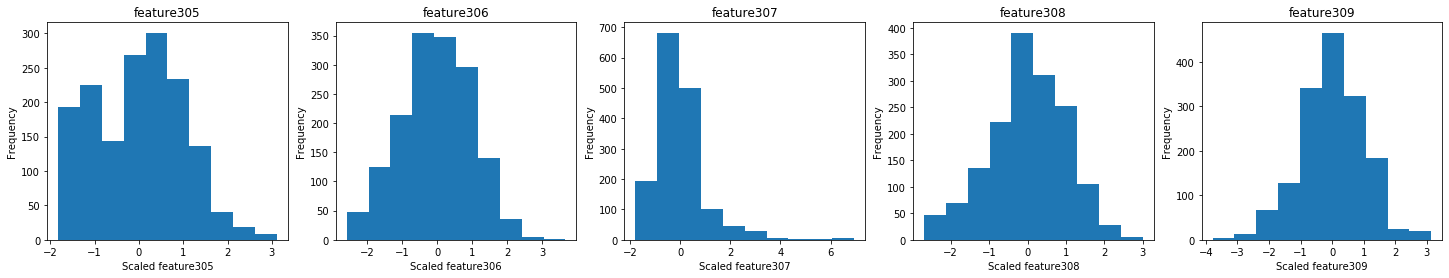

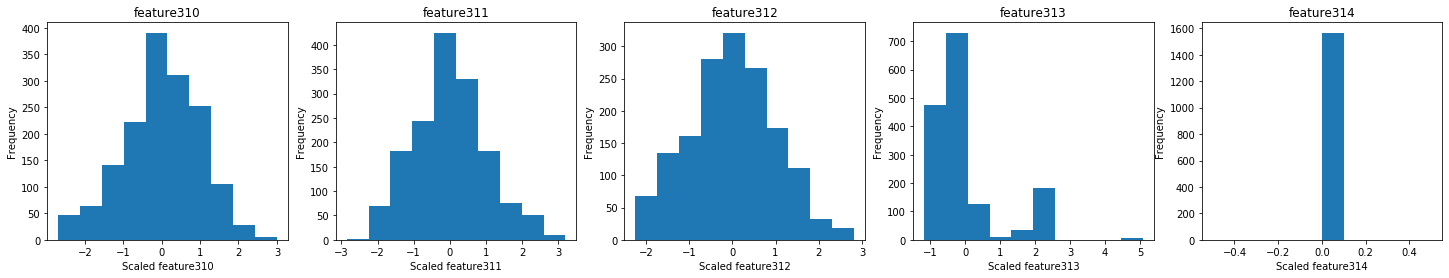

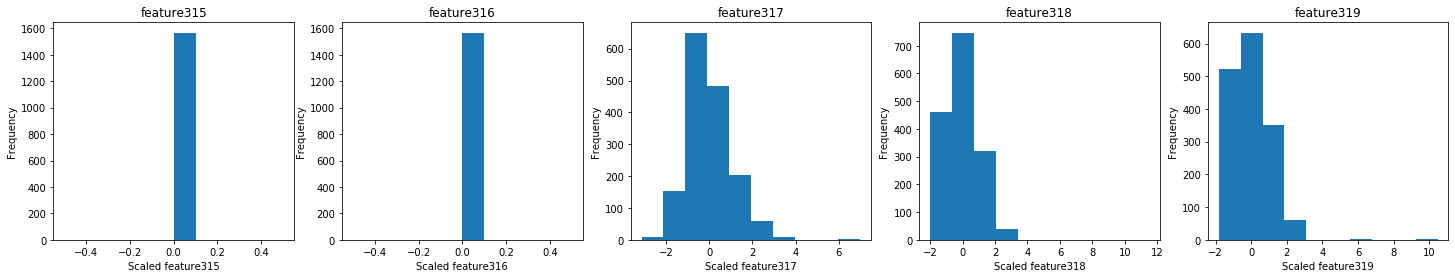

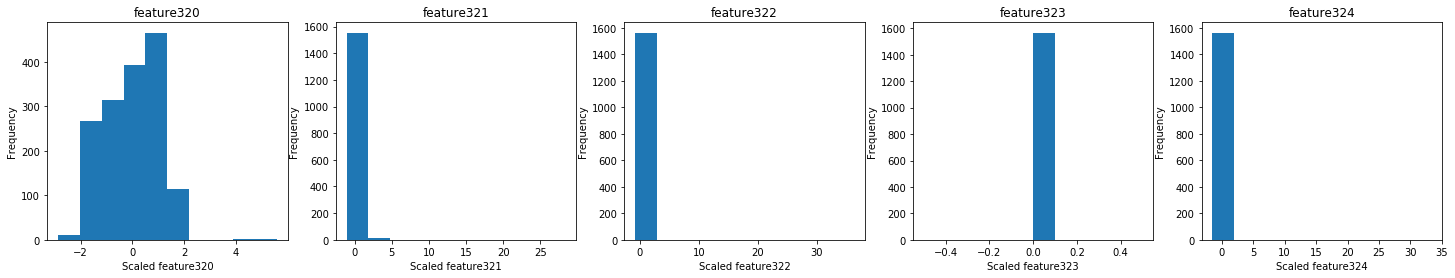

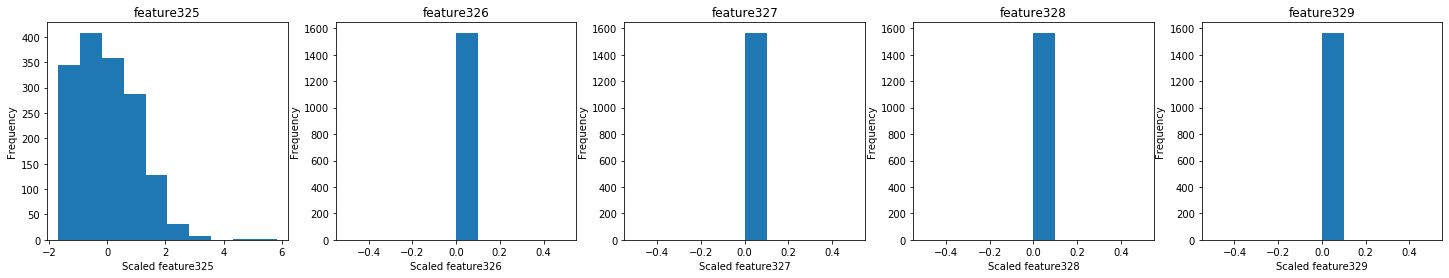

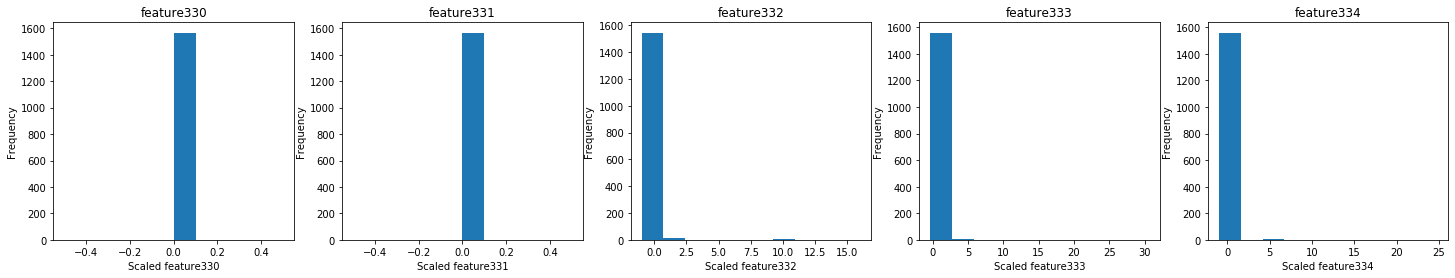

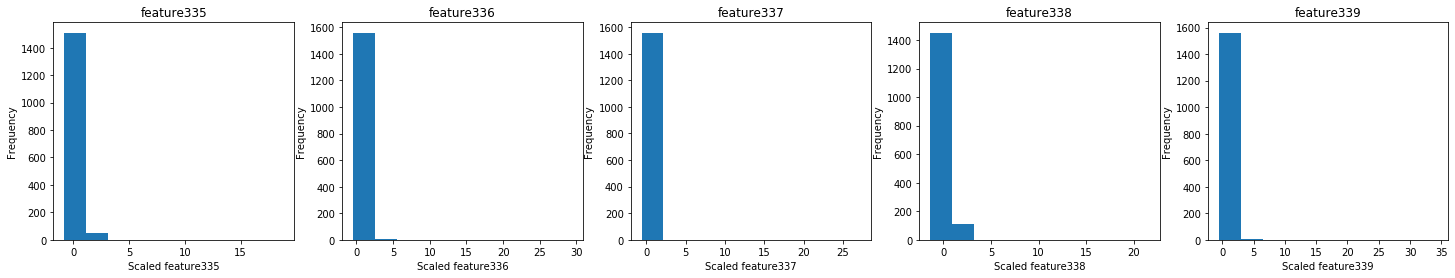

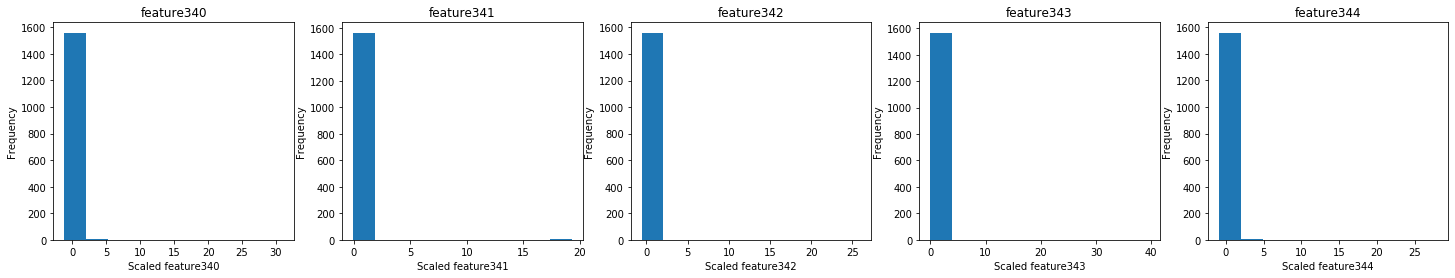

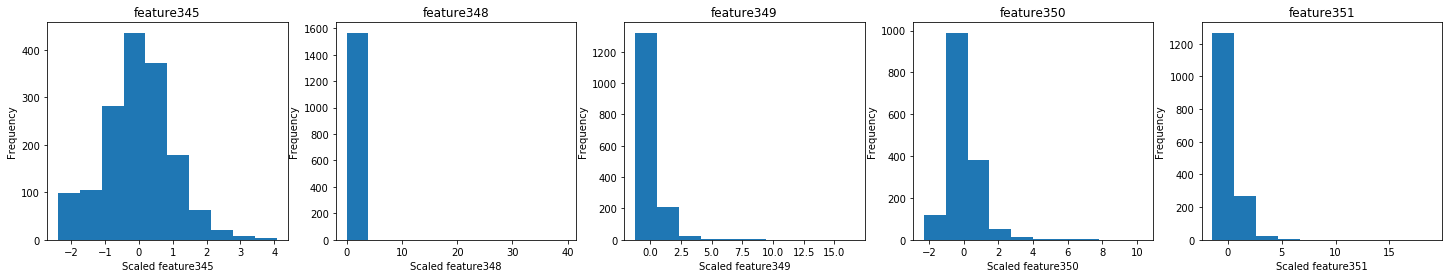

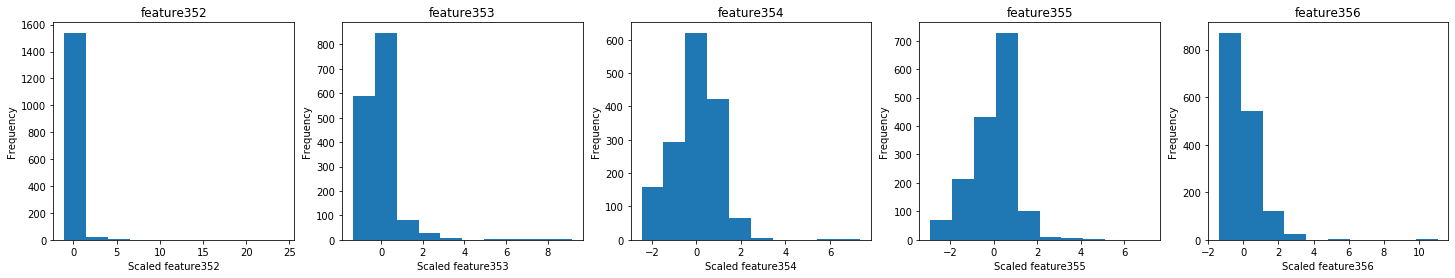

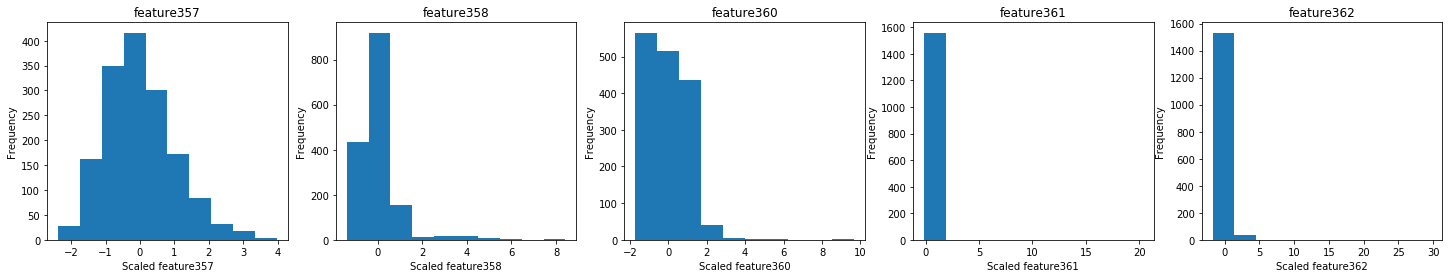

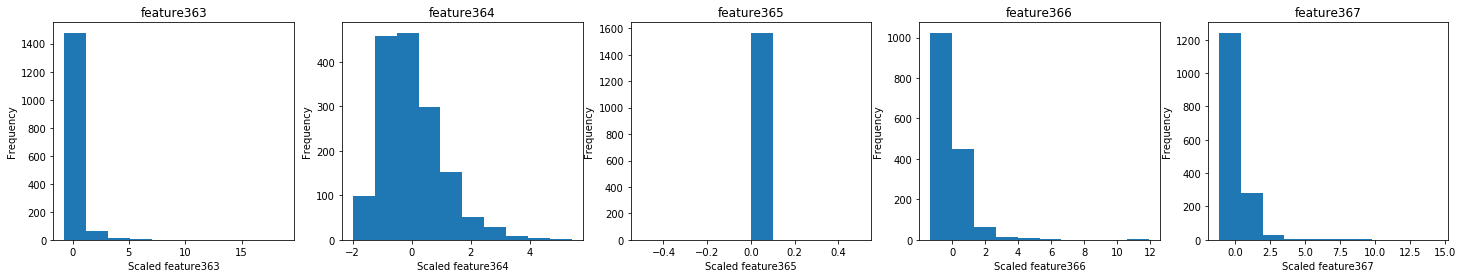

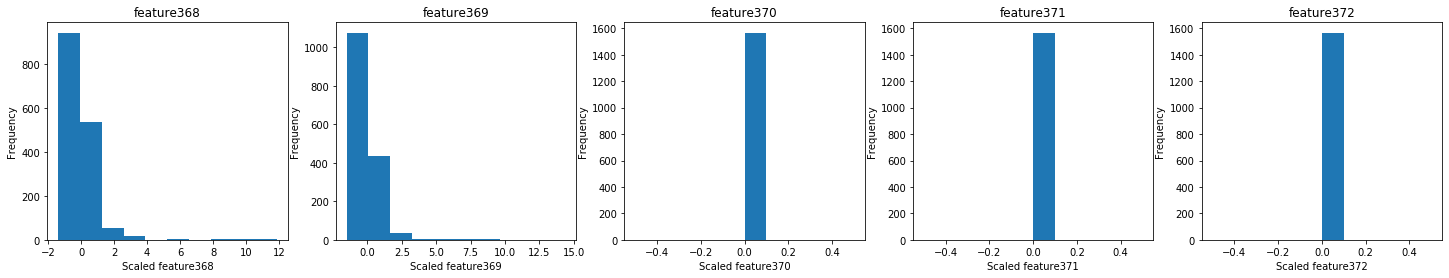

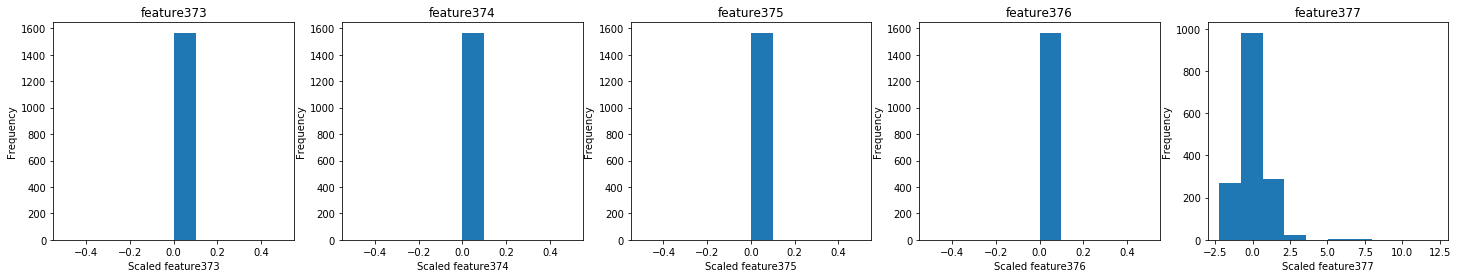

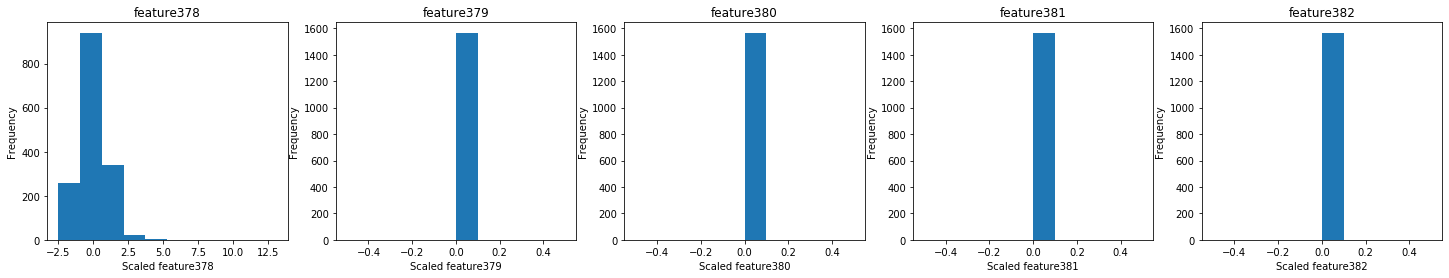

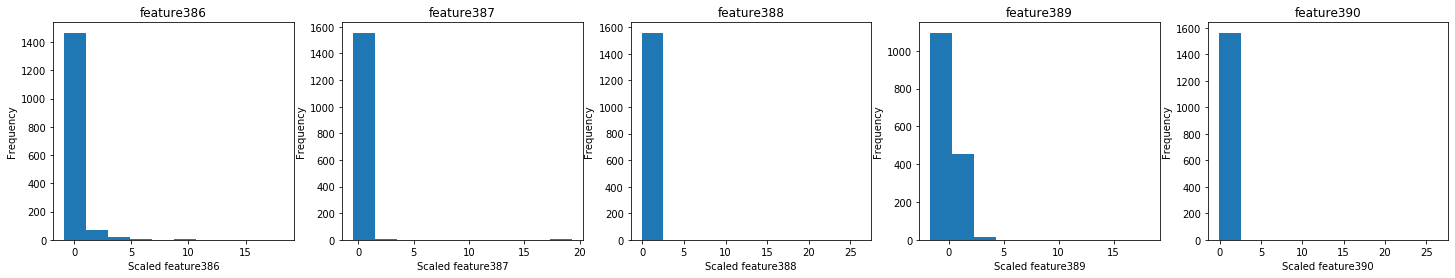

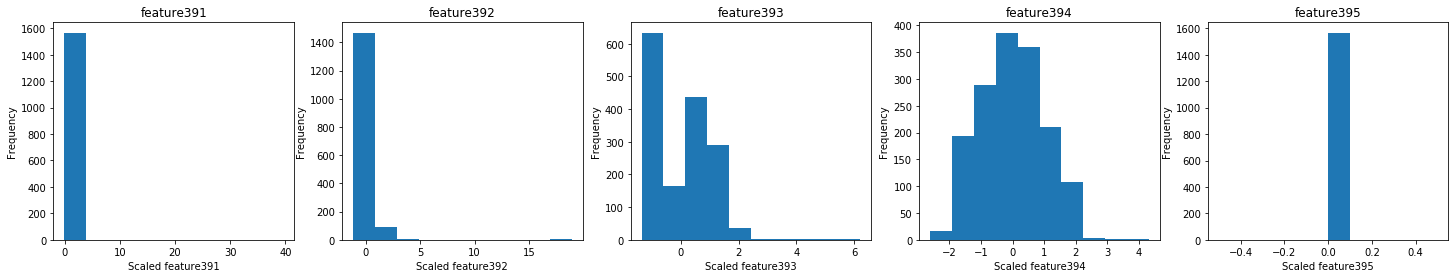

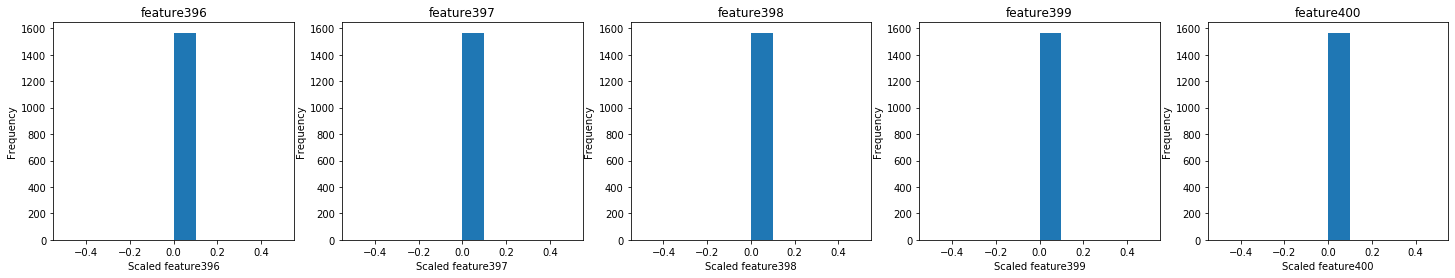

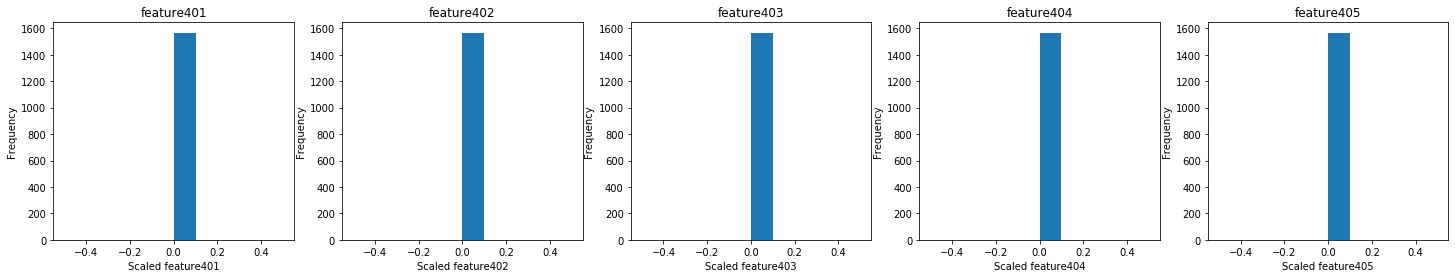

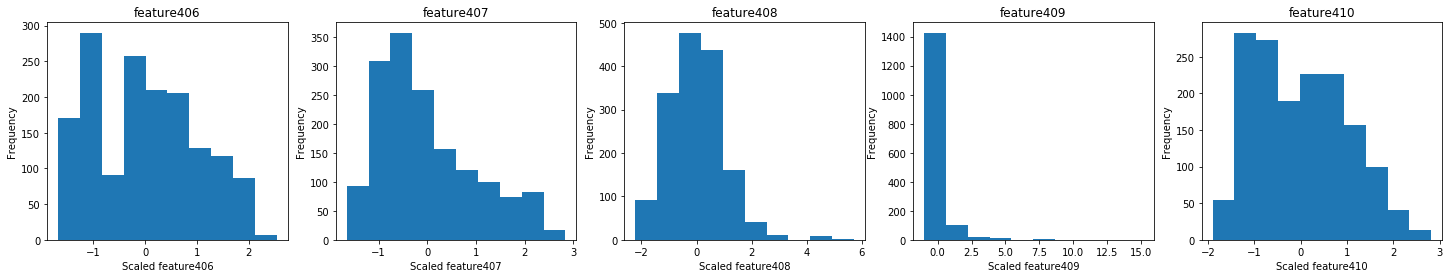

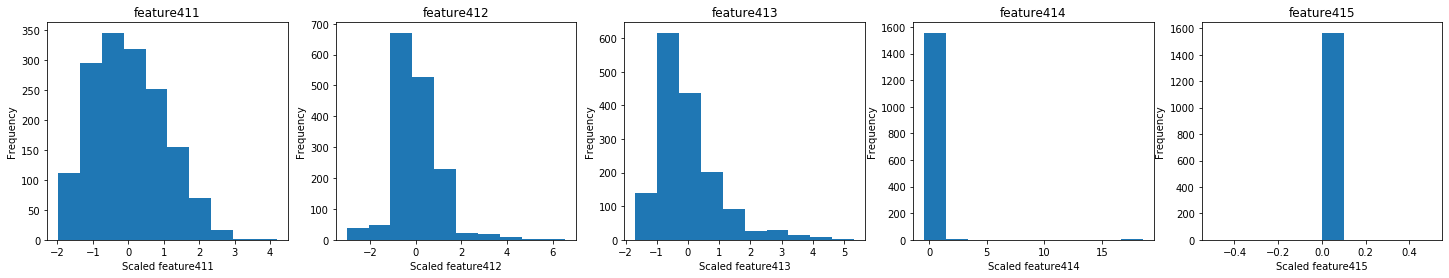

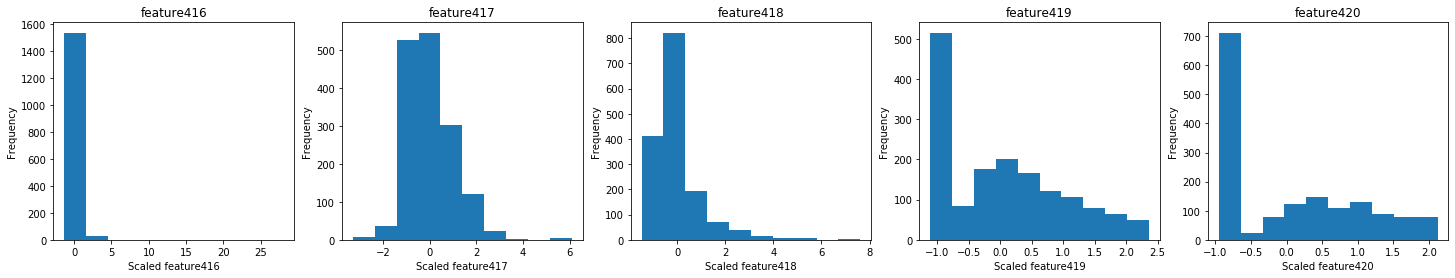

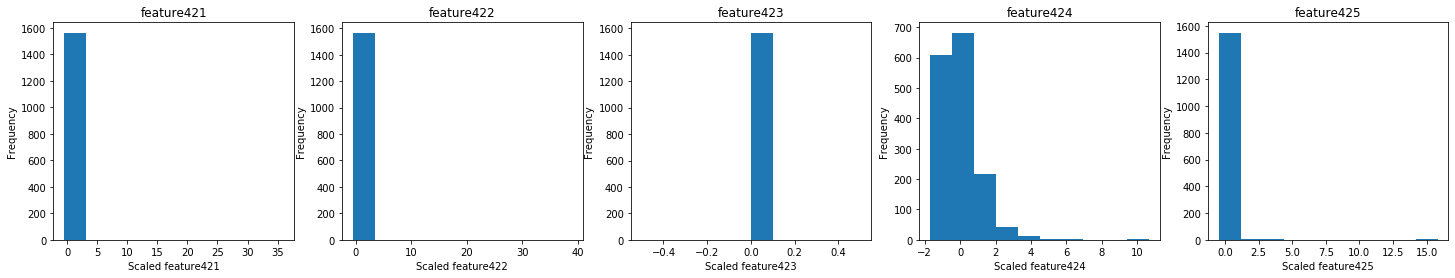

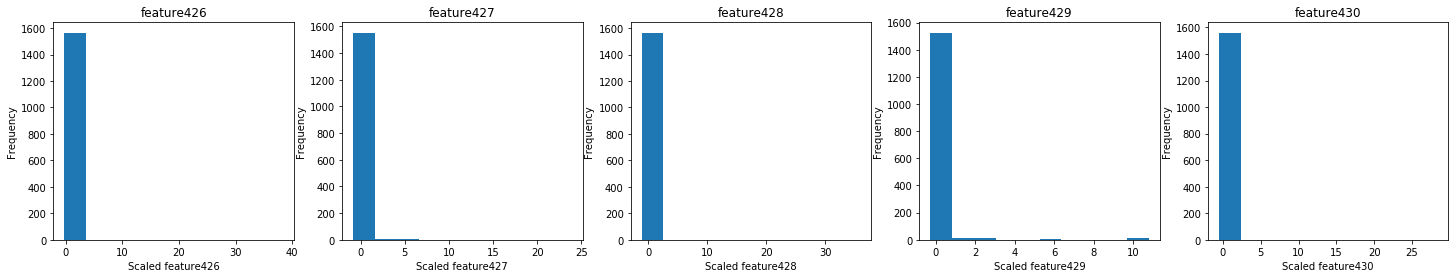

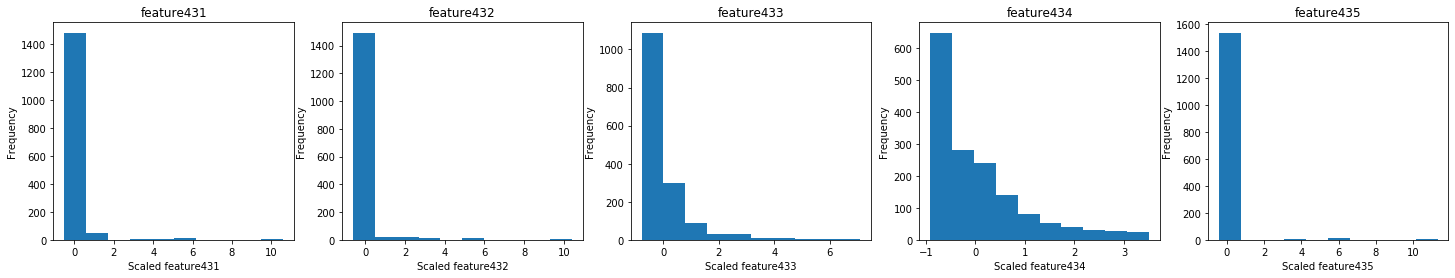

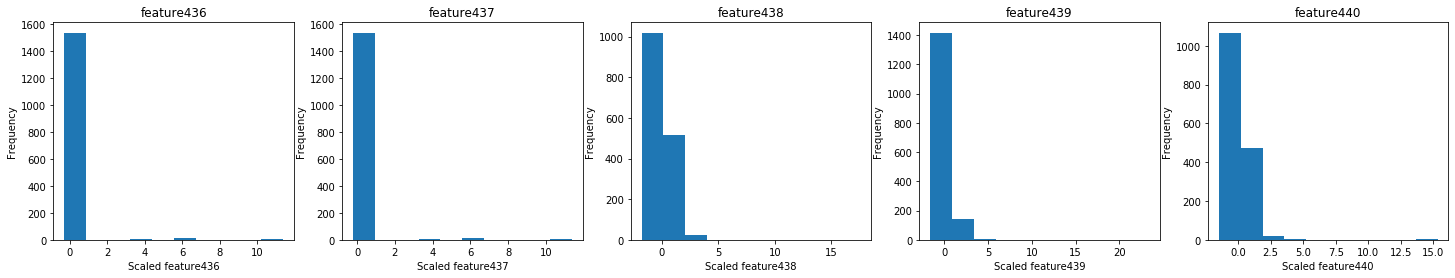

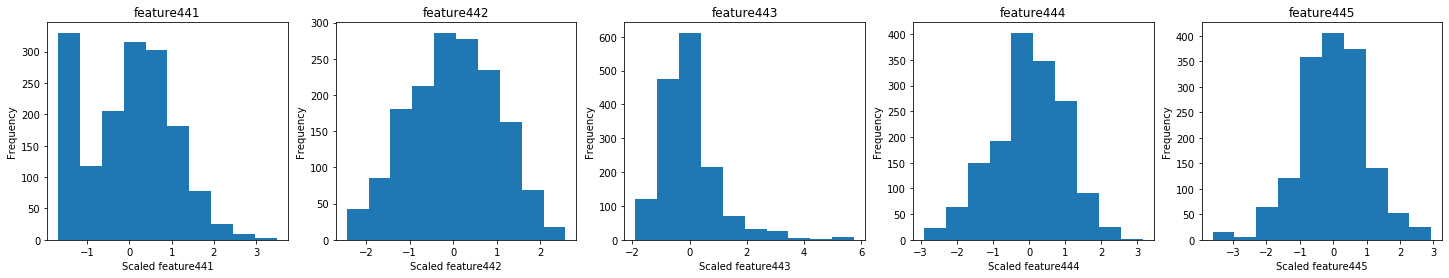

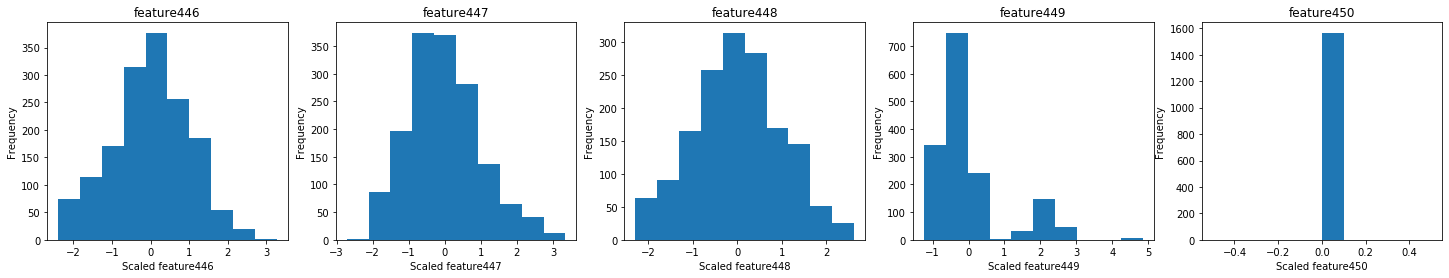

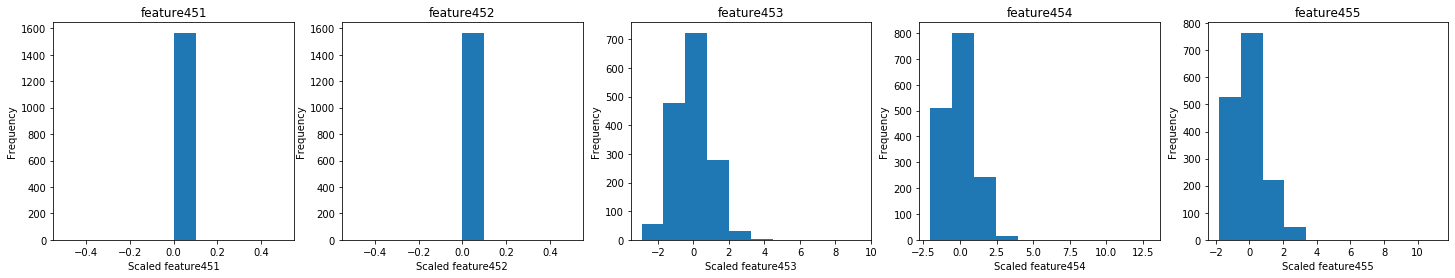

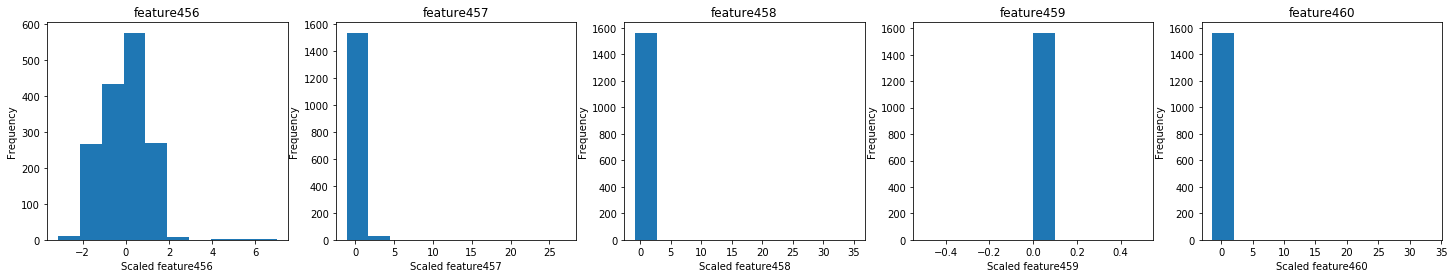

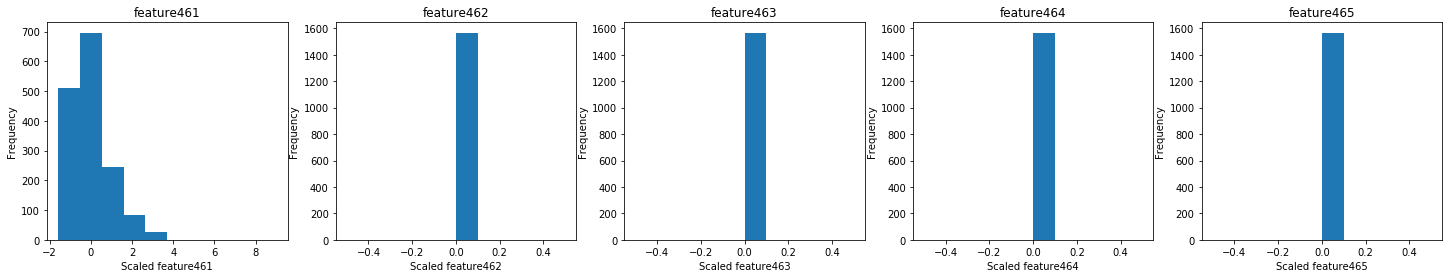

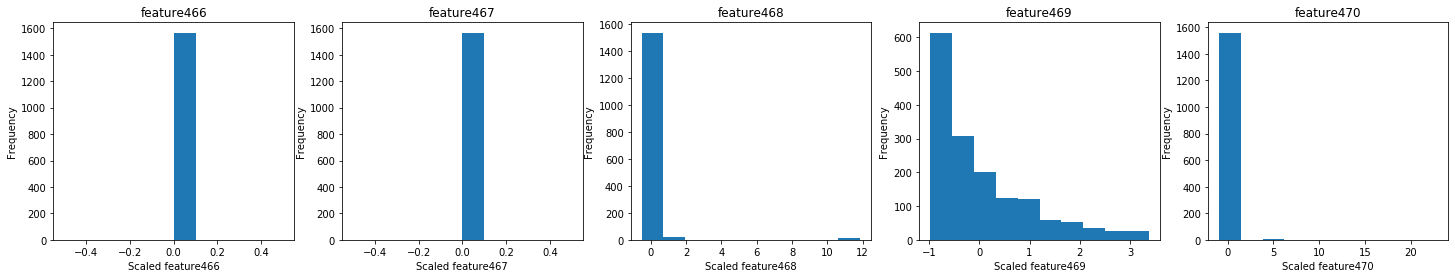

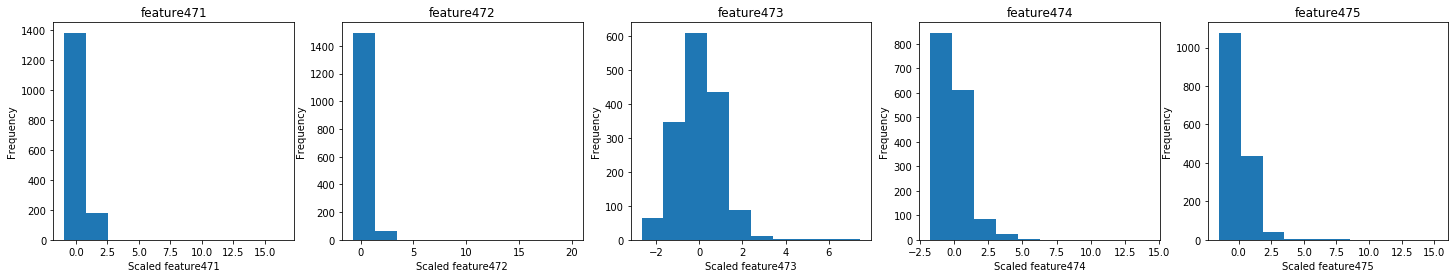

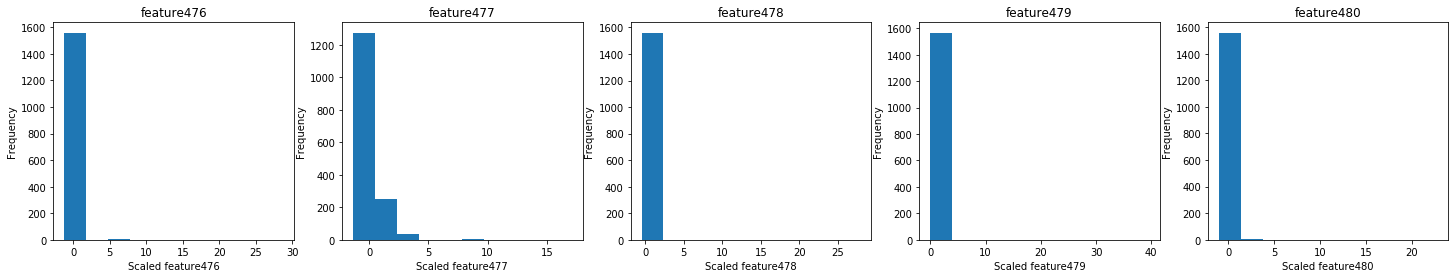

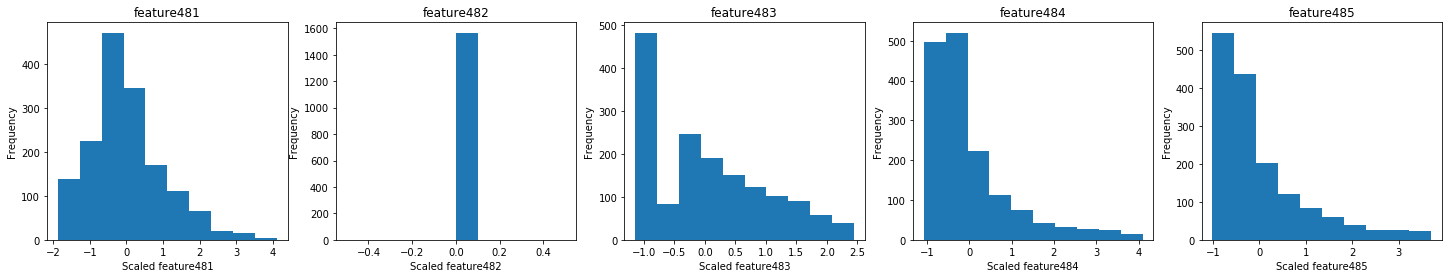

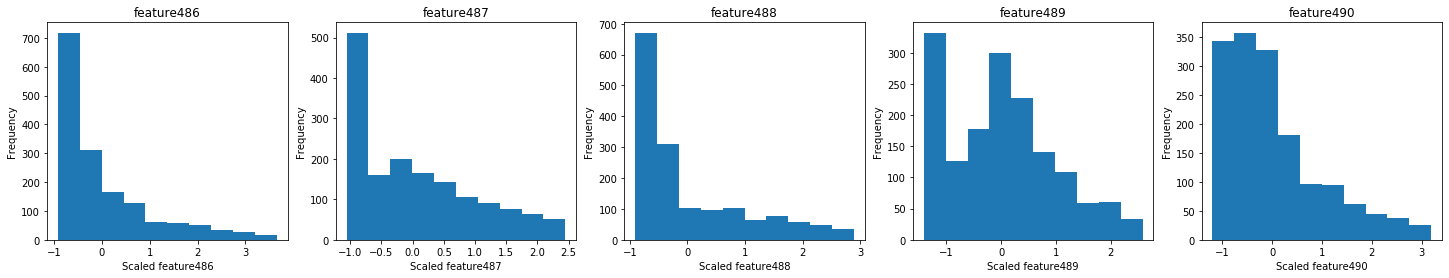

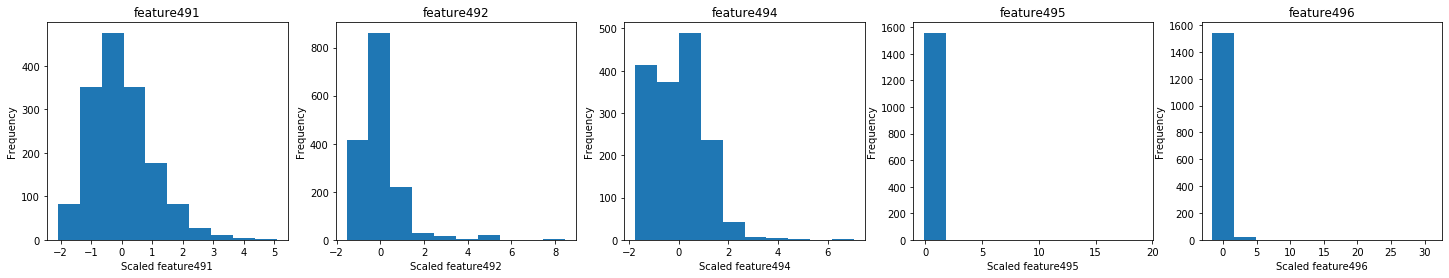

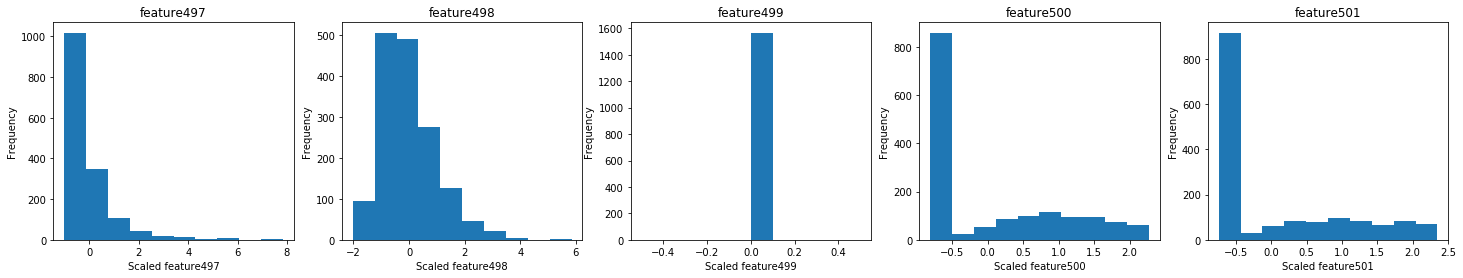

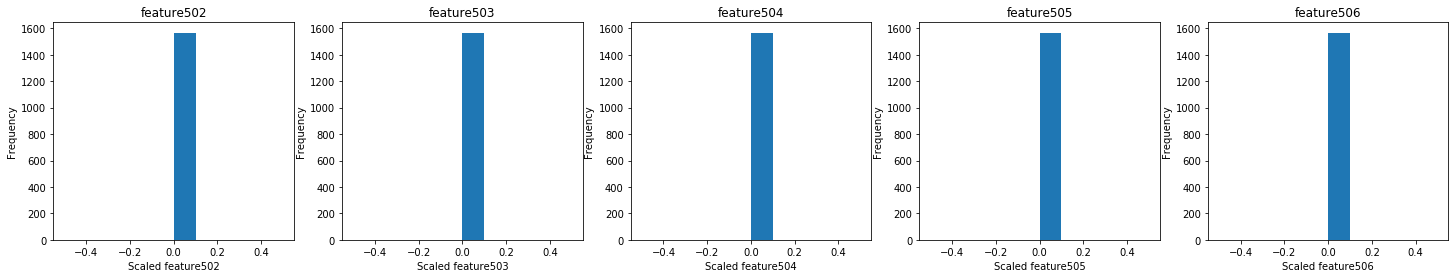

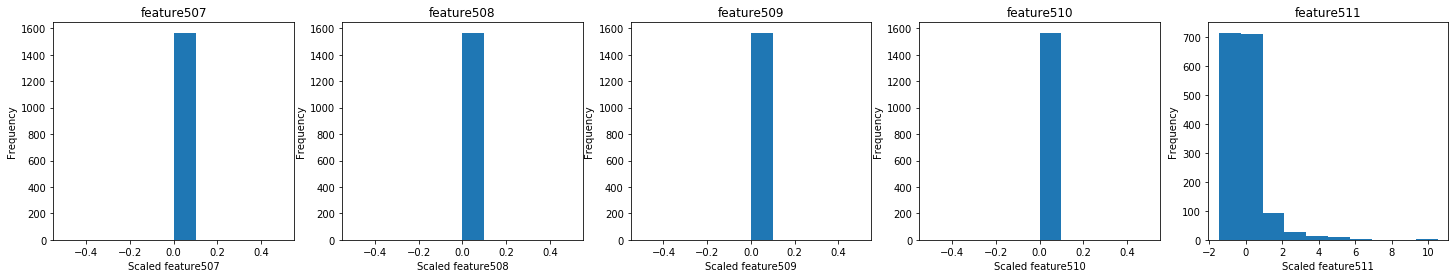

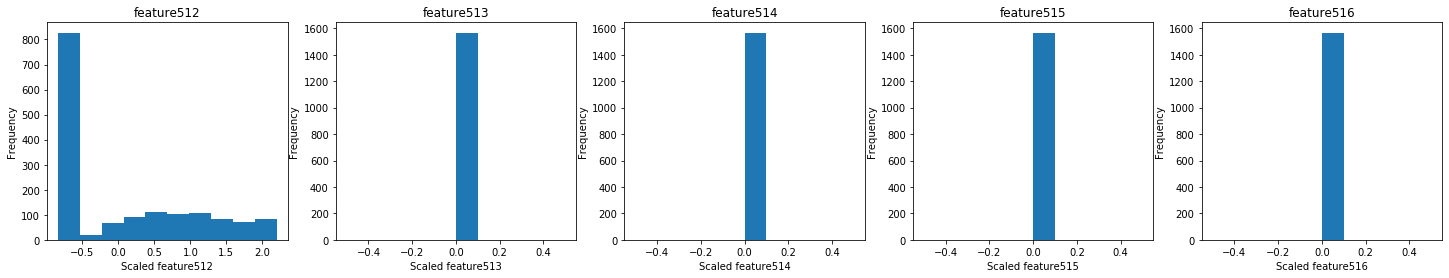

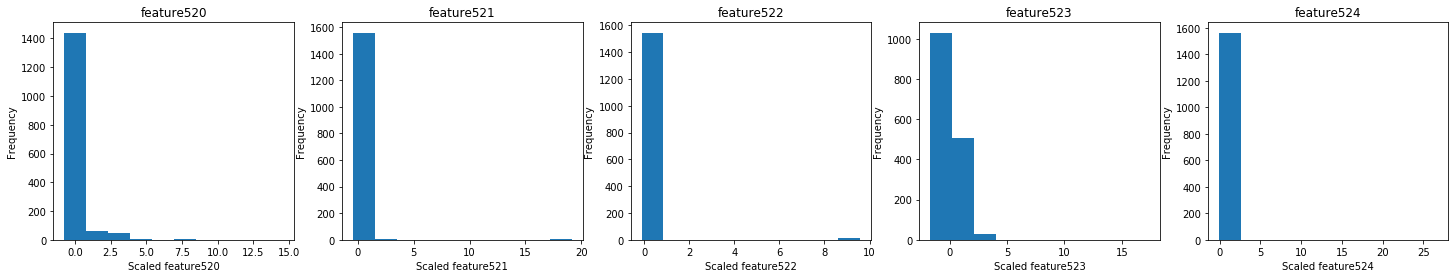

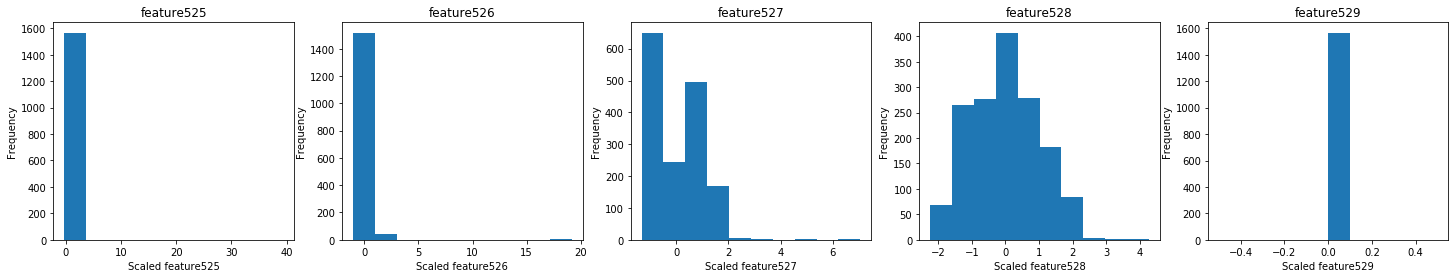

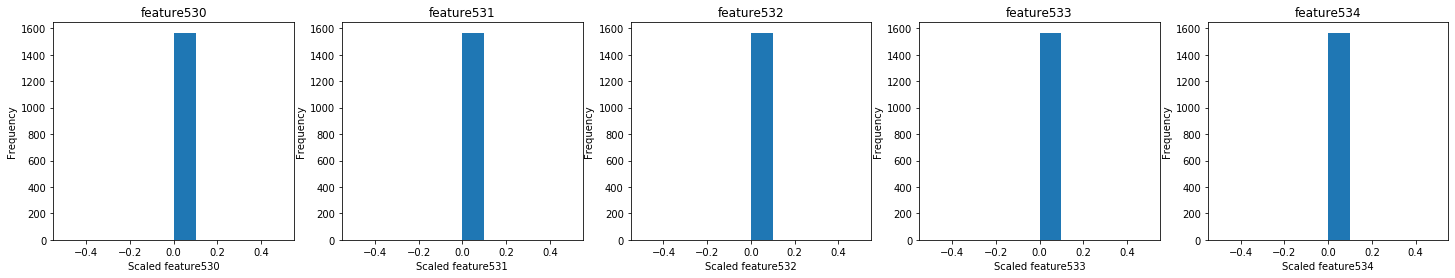

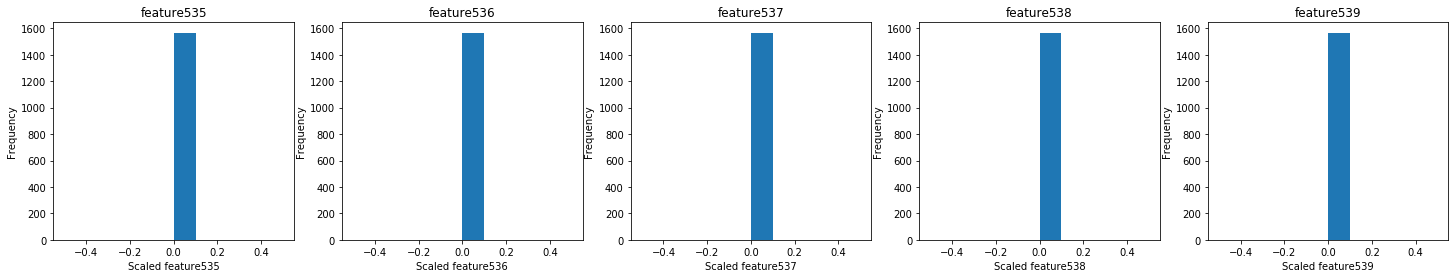

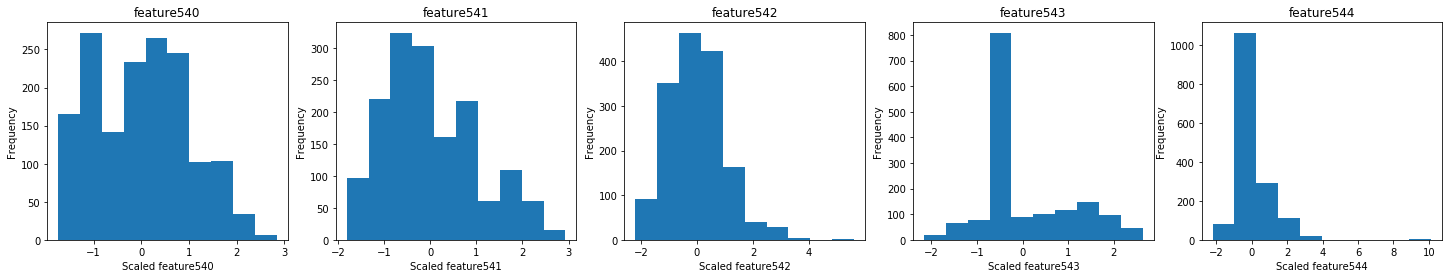

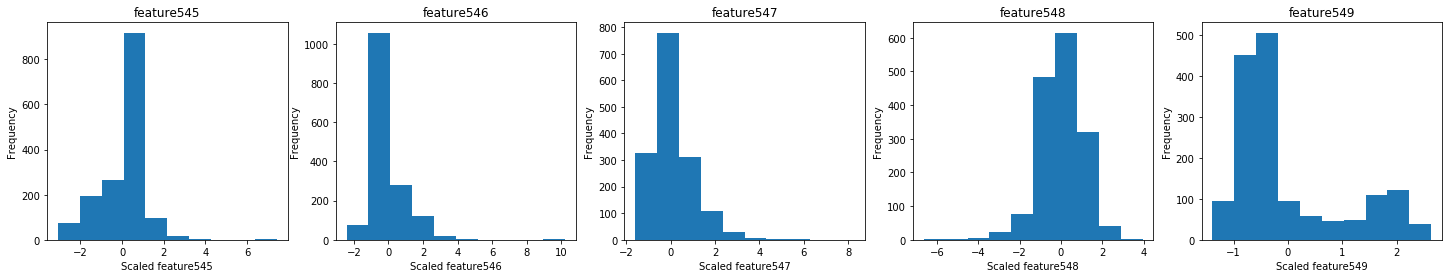

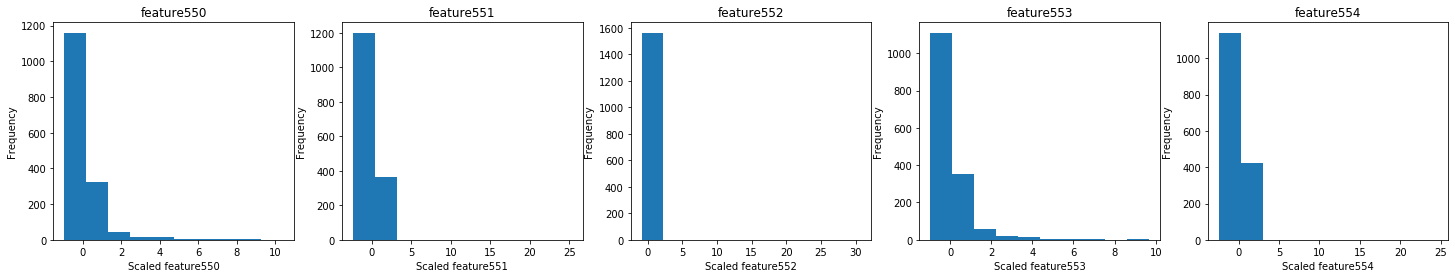

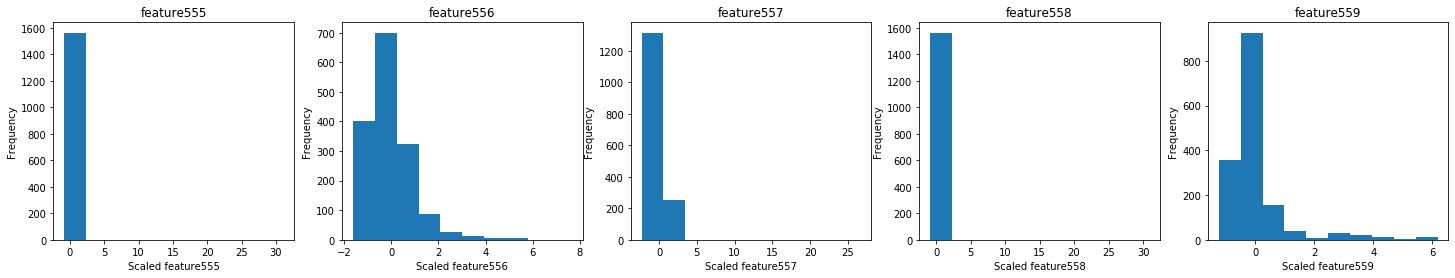

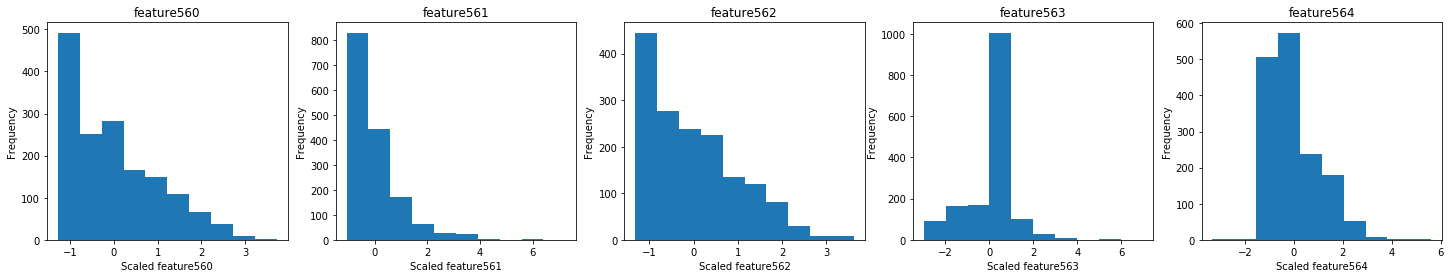

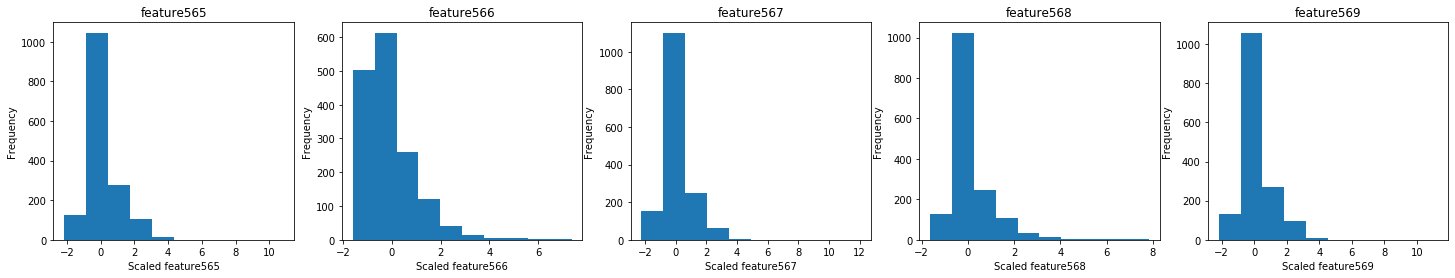

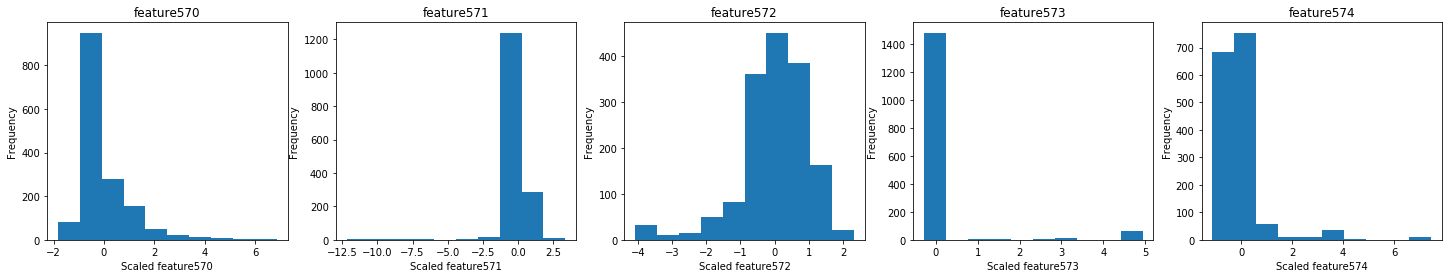

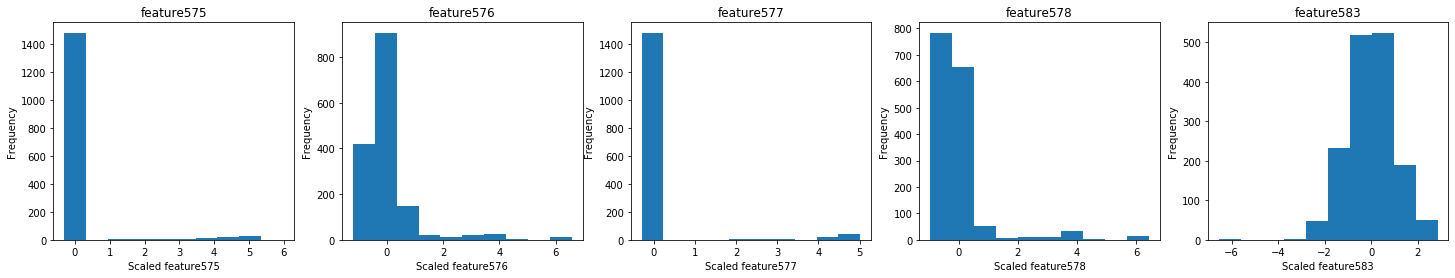

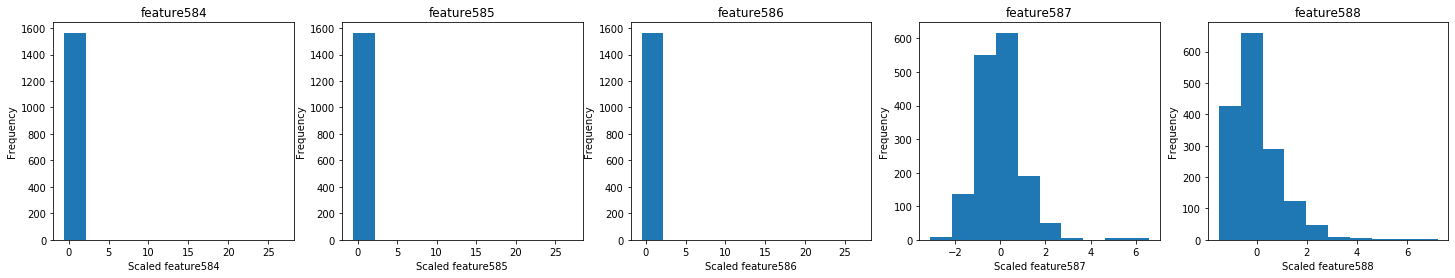

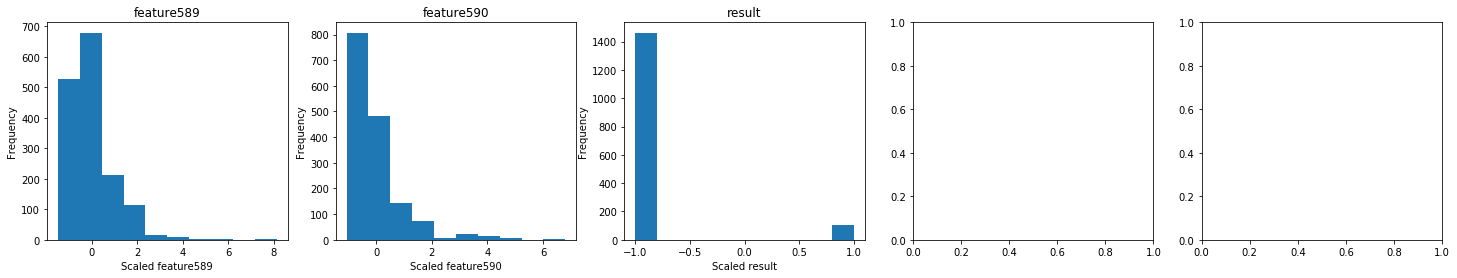

In [7]:
#plot distribution of each feature

for i in range (0,len(df_scaled.columns),5):
    fig, ax = plt.subplots(1, 5, figsize=(25,4))
    j = 0
    for col in df_scaled.iloc[:,i:i+5].columns:
        ax[j].hist(df_scaled[col])
        ax[j].set_title(col)
        ax[j].set_ylabel('Frequency')
        ax[j].set_xlabel('Scaled ' + col)
        j += 1

After performing EDA and analyzing the distribution, we notice that there are quite a few features that contain the same value in every row. Since these features are non-predictive, we will remove these features to further simplify our dataset.

In [8]:
#remove features that contain the same value in all rows

cols_to_drop = []

for col in df_scaled.drop('result', axis=1):
    if df_scaled[col].nunique() == 1:
        cols_to_drop.append(col)

print('No. of features that have the same value in all rows: ', len(cols_to_drop), '\n')

df_scaled2 = df_scaled.drop(cols_to_drop, axis=1)
print('Shape of Cleaned Dataset: ', df_scaled2.shape)
df_scaled2.head()

No. of features that have the same value in all rows:  116 

Shape of Cleaned Dataset:  (1567, 447)


,feature1,feature2,feature3,feature4,feature5,feature7,feature8,feature9,feature10,feature11,...,feature578,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590,result
0,0.224463,0.849523,-0.436430,0.035804,-0.050121,-0.564354,0.265894,0.509848,1.128455,-0.381577,...,-0.135520,0.118679,-0.204833,-0.093165,-0.197057,-0.077554,-0.190165,-0.238334,-0.295753,-1
1,1.107287,-0.383106,1.016977,0.155282,-0.059585,0.197639,0.321868,0.457021,0.022620,-1.608281,...,-0.460054,0.530183,0.406734,0.444748,0.385113,-0.960123,0.411970,0.250272,1.156846,-1
2,-1.114000,0.798901,-0.481447,0.688278,-0.047447,-0.906768,0.254699,-0.260885,0.327222,0.124169,...,-0.590505,-1.262799,0.022320,0.014418,0.029888,2.991195,3.627143,3.321511,-0.178955,1
3,-0.350156,-0.199072,-0.051705,-1.104376,-0.050831,0.502662,-0.013974,0.343240,-0.765369,-0.370817,...,-0.645708,-0.322218,-0.292200,-0.362121,-0.283360,-0.101845,-0.178804,-0.308135,-0.275049,-1
4,0.242296,0.087328,1.117227,-0.156616,-0.047033,-0.115954,0.187531,0.545066,-0.149545,-0.790478,...,-0.454486,-5.906917,26.867221,27.071429,26.913337,-0.101845,-0.178804,-0.308135,-0.275049,-1


## 5. Handle Class Imbalance

From the EDA plot, we notice that there's a significant class imbalance: 1463 for Outome = -1 and 104 for Outcome = 1. We need to handle this class imbalance to improve our future score metrics. We will achieve this by applying the SMOTE technique on the dataset.

In [9]:
#assign features and target to x and y

X = df_scaled2.drop('result', axis=1)
y = df_scaled2['result']

In [10]:
#apply smote to training data set to handle class imbalace

sm = SMOTE(random_state=1)

X_res, y_res = sm.fit_sample(X, y)

X_res = pd.DataFrame(X_res, columns=X.columns)

print('Resampled Training set shape:', X_res.shape)

X_res.head()

Resampled Training set shape: (2926, 446)


,feature1,feature2,feature3,feature4,feature5,feature7,feature8,feature9,feature10,feature11,...,feature577,feature578,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590
0,0.224463,0.849523,-0.436430,0.035804,-0.050121,-0.564354,0.265894,0.509848,1.128455,-0.381577,...,-0.229797,-0.135520,0.118679,-0.204833,-0.093165,-0.197057,-0.077554,-0.190165,-0.238334,-0.295753
1,1.107287,-0.383106,1.016977,0.155282,-0.059585,0.197639,0.321868,0.457021,0.022620,-1.608281,...,-0.263493,-0.460054,0.530183,0.406734,0.444748,0.385113,-0.960123,0.411970,0.250272,1.156846
2,-1.114000,0.798901,-0.481447,0.688278,-0.047447,-0.906768,0.254699,-0.260885,0.327222,0.124169,...,-0.205046,-0.590505,-1.262799,0.022320,0.014418,0.029888,2.991195,3.627143,3.321511,-0.178955
3,-0.350156,-0.199072,-0.051705,-1.104376,-0.050831,0.502662,-0.013974,0.343240,-0.765369,-0.370817,...,-0.224950,-0.645708,-0.322218,-0.292200,-0.362121,-0.283360,-0.101845,-0.178804,-0.308135,-0.275049
4,0.242296,0.087328,1.117227,-0.156616,-0.047033,-0.115954,0.187531,0.545066,-0.149545,-0.790478,...,-0.230791,-0.454486,-5.906917,26.867221,27.071429,26.913337,-0.101845,-0.178804,-0.308135,-0.275049


We will create two models, one using original dataset and one using the rebalanced dataset.

In [11]:
#logistic regression 

#with original non-rebalanced data
logreg = LogisticRegression(random_state=1)
logreg.fit(X, y)

print('Model score using original non-rebalanced data:', logreg.score(X, y).round(3))


#with rebalanced data
logreg_res = LogisticRegression(random_state=1)
logreg_res.fit(X_res, y_res)

print('Model score using rebalanced data:', logreg_res.score(X_res, y_res).round(3))

print('\n')

print('Classification Report - Original Data: \n', classification_report(y, logreg.predict(X)))
print('\n')
print('Classification Report - Rebalanced Data: \n', classification_report(y_res, logreg_res.predict(X_res)))


/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Model score using original non-rebalanced data: 0.977


/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Model score using rebalanced data: 0.982


Classification Report - Original Data: 
               precision    recall  f1-score   support

          -1       0.98      1.00      0.99      1463
           1       0.97      0.67      0.80       104

   micro avg       0.98      0.98      0.98      1567
   macro avg       0.97      0.84      0.89      1567
weighted avg       0.98      0.98      0.98      1567



Classification Report - Rebalanced Data: 
               precision    recall  f1-score   support

          -1       1.00      0.96      0.98      1463
           1       0.97      1.00      0.98      1463

   micro avg       0.98      0.98      0.98      2926
   macro avg       0.98      0.98      0.98      2926
weighted avg       0.98      0.98      0.98      2926



Using the rebalanced data, our Recall score goes up from 0.67 (using original data) to 1. At the same time, the Precision score isn't affected much.

## 6. Feature Selection

Our cleaned dataset has a few hundred features. To further simplify our dataset, we will reduce dimensionality by applying several Feature Selection techniques.

### 6.1 Filter Methods: Correlation Coefficient & Mutual Information

In [12]:
#define mutual information function

def calc_MI(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency = c_xy)
    return mi

#### 6.1.1 Filter - Correlation Coefficient

In [13]:
#calculate correlation coefficient for each feature to the target

corr = pd.DataFrame(np.corrcoef(X_res[i], y_res)[0, 1] for i in X_res.columns).rename(columns={0:'Corr Coef'})

corr = corr.set_index(X_res.columns)

In [14]:
#split correlation coefficients into positive & negative correlation groups

corr_pos = corr[corr['Corr Coef'] > 0]
corr_neg = corr[corr['Corr Coef'] < 0]

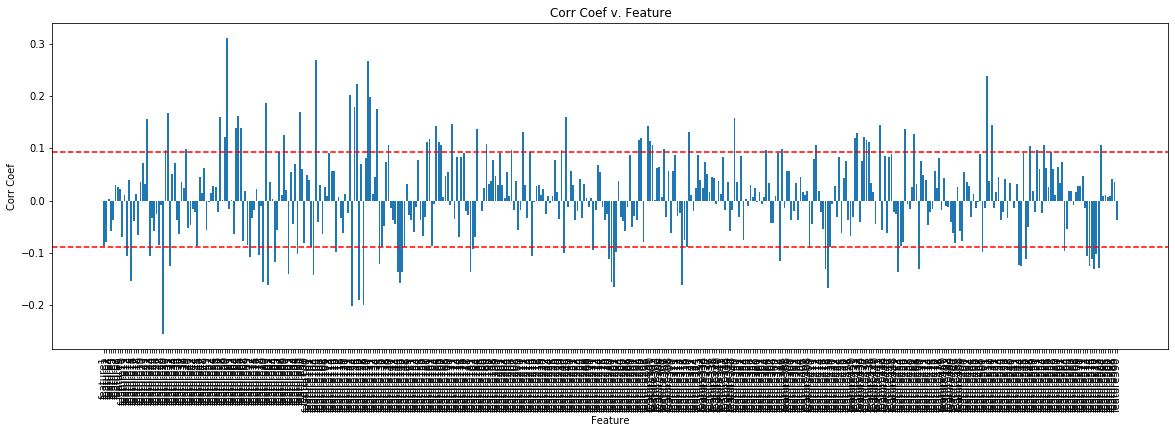

In [15]:
#plot coorelation coefficient

plt.figure(figsize=(20,6))
plt.bar(corr.index, corr['Corr Coef'])
plt.title('Corr Coef v. Feature')
plt.ylabel('Corr Coef')
plt.xlabel('Feature')
plt.xticks(rotation=90)
plt.axhline(y=np.percentile(corr_pos, 75), color='r', linestyle='--')
plt.axhline(y=np.percentile(corr_neg, 25), color='r', linestyle='--')
plt.show()

In [16]:
#selected features

print('Based on the Correlation Coefficient values, features selected are:')

a = 1
features_corr = []

print('Positively Correlated:')
#select features in the in the top 25th percentile
for i in corr[corr['Corr Coef'] > np.percentile(corr_pos, 75)].index:
    print(a, '-', i)
    features_corr.append(i)
    a += 1
    
print('\n')

a = 1
print('Inversely Correlated:')
#select features in the in the bottom 25th percentile
for i in corr[corr['Corr Coef'] < np.percentile(corr_neg, 25)].index:
    print(a, '-', i)
    features_corr.append(i)
    a += 1

Based on the Correlation Coefficient values, features selected are:
Positively Correlated:
1 - feature22
2 - feature30
3 - feature31
4 - feature39
5 - feature57
6 - feature59
7 - feature60
8 - feature64
9 - feature65
10 - feature66
11 - feature80
12 - feature87
13 - feature89
14 - feature96
15 - feature104
16 - feature122
17 - feature124
18 - feature125
19 - feature130
20 - feature131
21 - feature134
22 - feature139
23 - feature160
24 - feature161
25 - feature164
26 - feature165
27 - feature166
28 - feature171
29 - feature184
30 - feature189
31 - feature206
32 - feature211
33 - feature214
34 - feature239
35 - feature248
36 - feature295
37 - feature296
38 - feature299
39 - feature300
40 - feature301
41 - feature306
42 - feature320
43 - feature349
44 - feature364
45 - feature386
46 - feature412
47 - feature431
48 - feature432
49 - feature435
50 - feature436
51 - feature437
52 - feature442
53 - feature456
54 - feature461
55 - feature511
56 - feature520
57 - feature548
58 - feature551
59 -

#### 6.1.2 Filter - Mutual Information

In [17]:
#calculate mutual information for each feature to the target

mi = pd.DataFrame(calc_MI(X_res[i], y_res, 50) for i in X_res.columns).rename(columns={0: 'Mutual Info'})

mi = mi.set_index(X_res.columns)

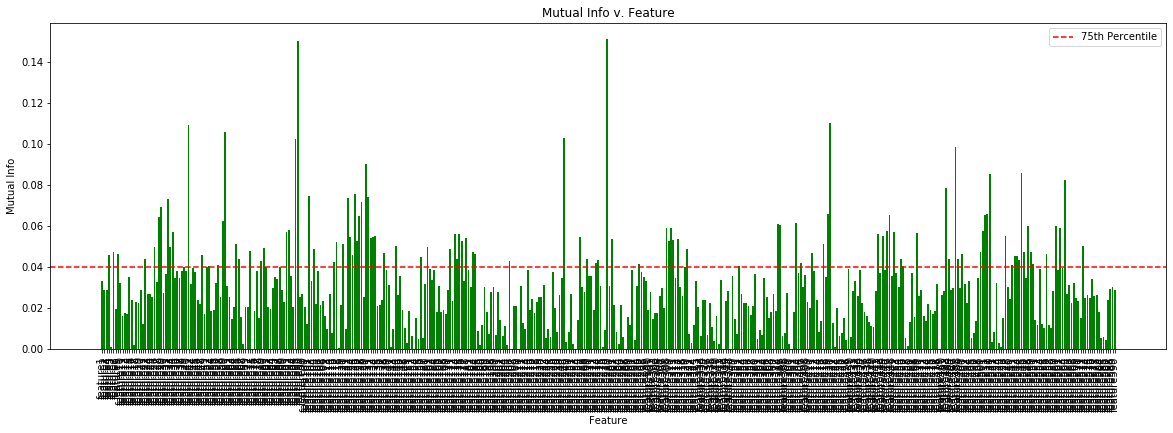

In [18]:
#plot mutual information

plt.figure(figsize=(20,6))
plt.bar(mi.index, mi['Mutual Info'], color='g')
plt.title('Mutual Info v. Feature')
plt.ylabel('Mutual Info')
plt.xlabel('Feature')
plt.xticks(rotation=90)
plt.axhline(y=np.percentile(mi, 75), color='r', linestyle='--', label='75th Percentile')
plt.legend()
plt.show()

In [19]:
#selected features

print('Based on the Mutual Information values, features selected are:')

a = 1
features_mi = []
for i in mi[mi['Mutual Info']>np.percentile(mi, 75)].index:
    print(a, '-', i)
    features_mi.append(i)
    a += 1

Based on the Mutual Information values, features selected are:
1 - feature4
2 - feature7
3 - feature9
4 - feature22
5 - feature26
6 - feature28
7 - feature29
8 - feature32
9 - feature33
10 - feature34
11 - feature39
12 - feature41
13 - feature48
14 - feature52
15 - feature57
16 - feature59
17 - feature60
18 - feature65
19 - feature66
20 - feature72
21 - feature79
22 - feature80
23 - feature91
24 - feature92
25 - feature95
26 - feature96
27 - feature102
28 - feature104
29 - feature116
30 - feature117
31 - feature120
32 - feature122
33 - feature123
34 - feature124
35 - feature125
36 - feature126
37 - feature127
38 - feature128
39 - feature130
40 - feature131
41 - feature132
42 - feature133
43 - feature134
44 - feature138
45 - feature144
46 - feature156
47 - feature161
48 - feature171
49 - feature173
50 - feature174
51 - feature175
52 - feature176
53 - feature178
54 - feature183
55 - feature184
56 - feature206
57 - feature248
58 - feature255
59 - feature269
60 - feature273
61 - feature274

In [20]:
#results comparison

print('No. of features selected using Filter Corr Coef: ', len(features_corr))
print('No. of features selected using Filter Mutual Info: ', len(features_mi))

#predict result using corr coef selection
yhat_corr = LogisticRegression(random_state=1).fit(X_res[features_corr], y_res).predict(X_res[features_corr])

#predict result using mutual info regression
yhat_mi = LogisticRegression(random_state=1).fit(X_res[features_mi], y_res).predict(X_res[features_mi])

print('\n')

print('Corr Coef between Corr Coef results, Mutual Info results and actual values: \n',
      np.corrcoef([yhat_corr, yhat_mi, y_res]))

No. of features selected using Filter Corr Coef:  112
No. of features selected using Filter Mutual Info:  112


/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)




Corr Coef between Corr Coef results, Mutual Info results and actual values: 
 [[1.         0.73312251 0.67022652]
 [0.73312251 1.         0.71589516]
 [0.67022652 0.71589516 1.        ]]


We see that the correlation coefficient between the results using the Corr Coef & MI techniques and actual values are 0.67 and 0.72, respectively. We will try other techniques to see if we can increase the values.

### 6.2 Wrapper Methods

We also perform Feature Selection using the Wrapper Methods (Backward and Forward). This is an iterative process that trains a model and evaluate the model accuracy score. The process repeats until model accuracy is the highest. Below are the codes on how we perform the Backward and Forward techniques. However, due to the long processing time, we will not run the Forward technique.

#### 6.2.1 Wrapper - Backward

In [21]:
#apply wrapper backward technique

estimator = LogisticRegression();

#select 100 features (out of 466) and fit the model to the dataset
back_selector = RFE(estimator, n_features_to_select = 100, step = 1, verbose = False)
back_selector = back_selector.fit(X_res, y_res)

print("The mask of selected features:")
print(back_selector.support_)

print("Ranking is the inverse of order of removal (higher rank is the first feature removed):")
print(back_selector.ranking_)

/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: Futur

/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: Futur

/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: Futur

/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: Futur

/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: Futur

/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: Futur

/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: Futur

/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: Futur

/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: Futur

/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: Futur

The mask of selected features:
[False False False False False False False False  True False False False
 False False  True False False False False False False False False  True
  True False False  True  True False False False False False False False
 False False  True False False False  True False False False False False
  True False False  True False False  True  True  True  True False  True
  True  True  True  True False False False False False  True False False
 False False False False False False False False False False False False
 False False False False False  True False False False False False False
 False False False  True False False False False  True False False False
 False  True False False False False False False  True False  True  True
 False False False False False  True False False  True False False  True
 False False False False False False False False  True False False False
 False False False  True False False False  True False  True  True False
 False  True False  

In [22]:
#select features based on backward selection

f_back = pd.DataFrame(back_selector.support_).rename(columns={0: 'Feature Selected'})
f_back.set_index(X_res.columns, inplace=True)

a=1
features_back = []
print('Features Chosen:')
for i in X_res.loc[:,f_back['Feature Selected']].columns:
    print(a, '-', i)
    features_back.append(i)
    a += 1

Features Chosen:
1 - feature10
2 - feature17
3 - feature26
4 - feature27
5 - feature30
6 - feature31
7 - feature41
8 - feature46
9 - feature54
10 - feature57
11 - feature60
12 - feature61
13 - feature62
14 - feature63
15 - feature65
16 - feature66
17 - feature67
18 - feature68
19 - feature69
20 - feature78
21 - feature100
22 - feature113
23 - feature118
24 - feature123
25 - feature130
26 - feature132
27 - feature133
28 - feature139
29 - feature143
30 - feature146
31 - feature156
32 - feature165
33 - feature169
34 - feature171
35 - feature172
36 - feature175
37 - feature177
38 - feature189
39 - feature197
40 - feature205
41 - feature206
42 - feature211
43 - feature213
44 - feature217
45 - feature224
46 - feature228
47 - feature229
48 - feature240
49 - feature250
50 - feature269
51 - feature274
52 - feature278
53 - feature284
54 - feature288
55 - feature299
56 - feature303
57 - feature306
58 - feature307
59 - feature311
60 - feature312
61 - feature313
62 - feature320
63 - feature322
64 -

In [23]:
#results comparison

print('No. of features selected using Wrapped Backward: ', len(features_back))

print('\n')

#predict result using backward selection
yhat_backward = back_selector.predict(X_res)

print('Corr Coef between Backward Selection results and actual values: \n',
      np.corrcoef([yhat_backward, y_res]))

No. of features selected using Wrapped Backward:  100


Corr Coef between Backward Selection results and actual values: 
 [[1.         0.85614866]
 [0.85614866 1.        ]]


The correlation coefficient between the backward prediction and actual value is 0.856. This is higher than when we use the Filter methods.

#### 6.2.1 Wrapper - Forward

This technique measures accuracy improvement if a new feature is included to train the model. However, due to the long running time, we will not run the Forward technique in this project. Below is the code that we use to perform feature selection using the Wrapper Forward technique.

#forward selection

estimator = LogisticRegression()

stepwise_selector = SFS(estimator, 
    k_features = "parsimonious", 
    forward = True, 
    floating = False, 
    scoring = 'neg_mean_squared_error', 
    cv = 10)

stepwise_selector = stepwise_selector.fit(X_res.values, y_res)

#plot sfs performance

fig = plot_sfs(stepwise_selector.get_metric_dict(), kind = 'std_err', figsize=(25,8))
plt.title('Sequential selection (w. StdErr)')
plt.xticks(rotation=90)
plt.grid()
plt.show()

#performance result

print('K score when using all features: ', stepwise_selector.k_score_)

#print the selected features

ftr = 100

for key in ['avg_score', 'feature_names']:
    print(key, ': ', stepwise_selector.get_metric_dict()[ftr][key], '\n')

a = 1
forward_select = []
print('Features Chosen:')
for i in stepwise_selector.get_metric_dict()[ftr]['feature_names']:
    print(a, '-', X.columns[int(i)-1])
    forward_select.append(X.columns[int(i)-1])
    a += 1

The Backward and Forward techniques will select features that are important and will give us the highest model accuracy.

### 6.3 Embedded Methods

#### 6.3.1 Embedded - Lasso

In [24]:
#lasso technique using rebalanced data

lassocv = LassoCV(random_state=1)
lassocv.fit(X_res, y_res)

/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Co

/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: 

/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: 

/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: 

LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=1, selection='cyclic',
    tol=0.0001, verbose=False)

In [25]:
#model alpha, score & coef

lassocv_alpha = lassocv.alpha_
lassocv_score = lassocv.score(X_res, y_res)
lassocv_coef = lassocv.coef_

print('Lasso Alpha:', lassocv_alpha)
print('Lasso Model Score:', lassocv_score)
print('No. of chosen features: ', sum(lassocv_coef != 0))

Lasso Alpha: 0.00715041812181662
Lasso Model Score: 0.625658549469233
No. of chosen features:  180


In [26]:
#features chosen

ll = pd.DataFrame({'col': X_res.columns, 'coef': lassocv_coef})

a = 1
lasso_features = []

print('Features Chosen: \n')

for i in ll[ll['coef']!=0]['col']:
    print(a, '-', i)
    lasso_features.append(i)
    a += 1

Features Chosen: 

1 - feature1
2 - feature2
3 - feature3
4 - feature10
5 - feature11
6 - feature12
7 - feature15
8 - feature18
9 - feature21
10 - feature22
11 - feature23
12 - feature25
13 - feature26
14 - feature29
15 - feature30
16 - feature32
17 - feature33
18 - feature34
19 - feature36
20 - feature39
21 - feature40
22 - feature41
23 - feature42
24 - feature51
25 - feature54
26 - feature55
27 - feature56
28 - feature57
29 - feature59
30 - feature60
31 - feature61
32 - feature62
33 - feature65
34 - feature67
35 - feature68
36 - feature69
37 - feature72
38 - feature76
39 - feature78
40 - feature80
41 - feature81
42 - feature82
43 - feature85
44 - feature87
45 - feature88
46 - feature89
47 - feature90
48 - feature91
49 - feature92
50 - feature93
51 - feature94
52 - feature95
53 - feature100
54 - feature101
55 - feature102
56 - feature103
57 - feature108
58 - feature109
59 - feature113
60 - feature114
61 - feature116
62 - feature117
63 - feature118
64 - feature119
65 - feature120
66 - 

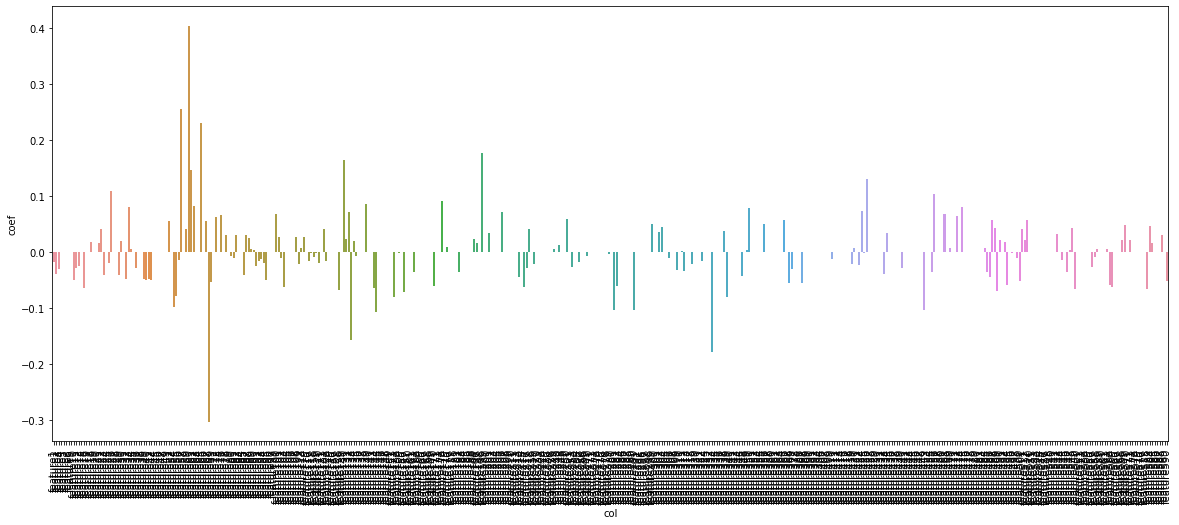

In [27]:
#plot feature coefficients

ll = pd.DataFrame({'col': X.columns, 'coef': lassocv.coef_})

plt.figure(figsize=(20,8))
ax = sns.barplot(x = 'col', y = 'coef', data = ll)
plt.xticks(rotation=90);

In [28]:
#results comparison

print('No. of features selected using Embedded Lasso: ', len(lasso_features))

#predict result using lasso technique
yhat_lasso = LogisticRegression(penalty='l1', random_state=1).fit(X_res, y_res).predict(X_res)
#LogisticRegression(random_state=1).fit(X_res[lasso_features], y_res).predict(X_res[lasso_features])

print('\n')

print('Corr Coef between Lasso Selection results and actual values: \n',
      np.corrcoef([yhat_lasso, y_res]))

No. of features selected using Embedded Lasso:  180


/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)




Corr Coef between Backward Selection results and actual values: 
 [[1.         0.97169236]
 [0.97169236 1.        ]]


#### 6.3.2 Embedded - Ridge

In [29]:
#ridge technique using rebalanced data

ridgecv = RidgeCV();
ridgecv.fit(X_res, y_res);

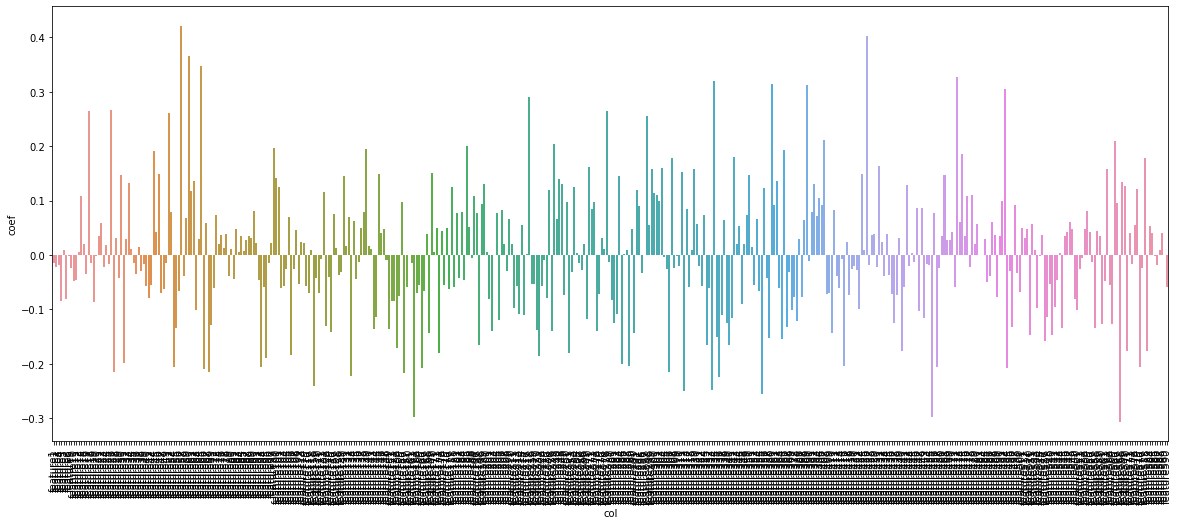

In [30]:
#plot feature coefficients

rr = pd.DataFrame({'col': X.columns, 'coef': ridgecv.coef_})

plt.figure(figsize=(20,8))
ax = sns.barplot(x = 'col', y = 'coef', data = rr)
plt.xticks(rotation=90);

In [31]:
#compare results using regular linear regression and ridge

#predict result using ridge technique
yhat_ridge = LogisticRegression(penalty='l2', random_state=1).fit(X_res, y_res).predict(X_res)
#yhat_ridge = ridge.predict(X_res)

print('Corr Coef between Backward Selection results and actual values: \n',
      np.corrcoef([yhat_ridge, y_res]))

/opt/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Corr Coef between Backward Selection results and actual values: 
 [[1.         0.96440612]
 [0.96440612 1.        ]]


### 7. Findings & Discussion

Our main goal for this project is to reduce dimensionality of our original dataset in order to simplify it before subsequent modeling steps and to prevent model overfitting. Another important thing to consider is that while we want to reduce dimensionality as much as possible, we want to make sure that the model performance (accuracy, etc.) will not be freatly compromised 


To start the project, we clean the data and remove several features that have too many missing values (50%+) and apply Standard Scaler to the data. We perform EDA and plot the distribution of each feature in the dataset. We notice that some features have the same input value (same value for all rows). Since these features are non-predictive, we remove them to further simplify our dataset. To handle the class imbalance in our dataset, we apply the SMOTE technique. As the final step of the project, we apply multiple Feature Selection techniques (Filter, Wrapper and Embedded methods) on our dataset and select the most important features.


Analyzing our results, we notice that the Filter methods offer very basic dimensionality reduction and do not work very well. While the Wrapper methods work better than the Filter methods, they are very time consuming and take up a lot of resources. Using Lasso technique, we are able to reduce the dimension in a short period of time and achieve a fairly high performance results and dimension reduction. We also notice that Ridge technique does not eliminate less important features the way Lasso technique does. Instead, it just minimizes the feature coefficients.


| Techniques | Corr Coef (v. actual) | No. of Features Selected | Pros | Cons |
| --- | --- | --- | --- | --- |
| Filter: Corr Coef | 67.2% | 112 | Simple | Too Simple |
| Filter: Mutual Info | 71.5% | 112 | Simple | Too Simple |
| Wrapper: Backward | 85.6% | 100 | OK Performance | Time Consuming |
| Wrapper: Forward | Not Run | Not Run | OK Performance | Very Time Consuming |
| Embedded: Lasso | 97.2% | 180 | Good Performance & Fast |  |
| Embedded: Ridge | 96.4% | All | OK Performance & Fast | Dimension Not Reduced |